In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
import time
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import pandas as pd
import seaborn as sns
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import OneHotEncoder, Binarizer, LabelEncoder
from scipy.stats import chi2_contingency
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import MetricFrame

In [26]:
# Direct link to CSV file
url = "https://data.cdc.gov/api/views/vc9m-u7tv/rows.csv?accessType=DOWNLOAD"

# Read data into a pandas DataFrame
df = pd.read_csv(url)

# Display first few rows
df.head()

,Year,Sex,Age Group (Years),Race,Injury Mechanism,Injury Intent,Deaths,Population,Age Specific Rate,Age Specific Rate Standard Error,Age Specific Rate Lower Confidence Limit,Age Specific Rate Upper Confidence Limit,Age Adjusted Rate,Age Adjusted Rate Standard Error,Age Adjusted Rate Lower Confidence Limit,Age Adjusted Rate Upper Confidence Limit
0,2016,Both sexes,All Ages,All races,All Mechanisms,All Intentions,231991,323127513,71.795496,0.149060,71.503338,72.087654,68.982236,0.1460097,68.696057,69.268415
1,2015,Both sexes,All Ages,All races,All Mechanisms,All Intentions,214008,321418820,66.582287,0.143928,66.300189,66.864384,63.866114,0.140507,63.59072,64.141508
2,2014,Both sexes,All Ages,All races,All Mechanisms,All Intentions,199752,318857056,62.646254,0.140168,62.371524,62.920983,60.127242,0.136713,59.859285,60.3952
3,2013,Both sexes,All Ages,All races,All Mechanisms,All Intentions,192945,316128839,61.033660,0.138948,60.761321,61.305998,58.771709,0.1357892,58.505562,59.037856
4,2012,Both sexes,All Ages,All races,All Mechanisms,All Intentions,190385,313914040,60.648769,0.138997,60.376334,60.921203,58.696255,0.1362913,58.429124,58.963386


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98280 entries, 0 to 98279
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Year                                      98280 non-null  int64  
 1   Sex                                       98280 non-null  object 
 2   Age Group (Years)                         98280 non-null  object 
 3   Race                                      98280 non-null  object 
 4   Injury Mechanism                          98280 non-null  object 
 5   Injury Intent                             98280 non-null  object 
 6   Deaths                                    98280 non-null  int64  
 7   Population                                98280 non-null  int64  
 8   Age Specific Rate                         98280 non-null  float64
 9   Age Specific Rate Standard Error          80093 non-null  float64
 10  Age Specific Rate Lower Confidence

In [28]:
# Summarize data group by Age Group, Injury Intent and Injury Mechanism
age_group_summary = df.groupby(['Age Group (Years)', 'Injury Intent', 'Injury Mechanism']).agg({
    'Deaths': 'sum',
    'Population': 'sum',
    'Age Specific Rate': 'mean'
}).reset_index()

# Display the summary
age_group_summary

,Age Group (Years),Injury Intent,Injury Mechanism,Deaths,Population,Age Specific Rate
0,15–24,All Intentions,All Mechanisms,1681842,2963190528,59.398606
1,15–24,All Intentions,All Other Specified,39106,2963190528,1.321690
2,15–24,All Intentions,All Other Transport,40754,2963190528,1.207107
3,15–24,All Intentions,Cut/pierce,31918,2963190528,1.453272
4,15–24,All Intentions,Drowning,45484,2963190528,1.675922
...,...,...,...,...,...,...
450,All Ages,Unintentional,Firearm,45082,21108613556,0.221306
451,All Ages,Unintentional,Motor vehicle traffic,2751152,21108613556,12.855250
452,All Ages,Unintentional,Poisoning,2103632,21108613556,8.713263
453,All Ages,Unintentional,Suffocation,429464,21108613556,1.850987


C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2031789666.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Intent', data=all_ages_data, ci = None)


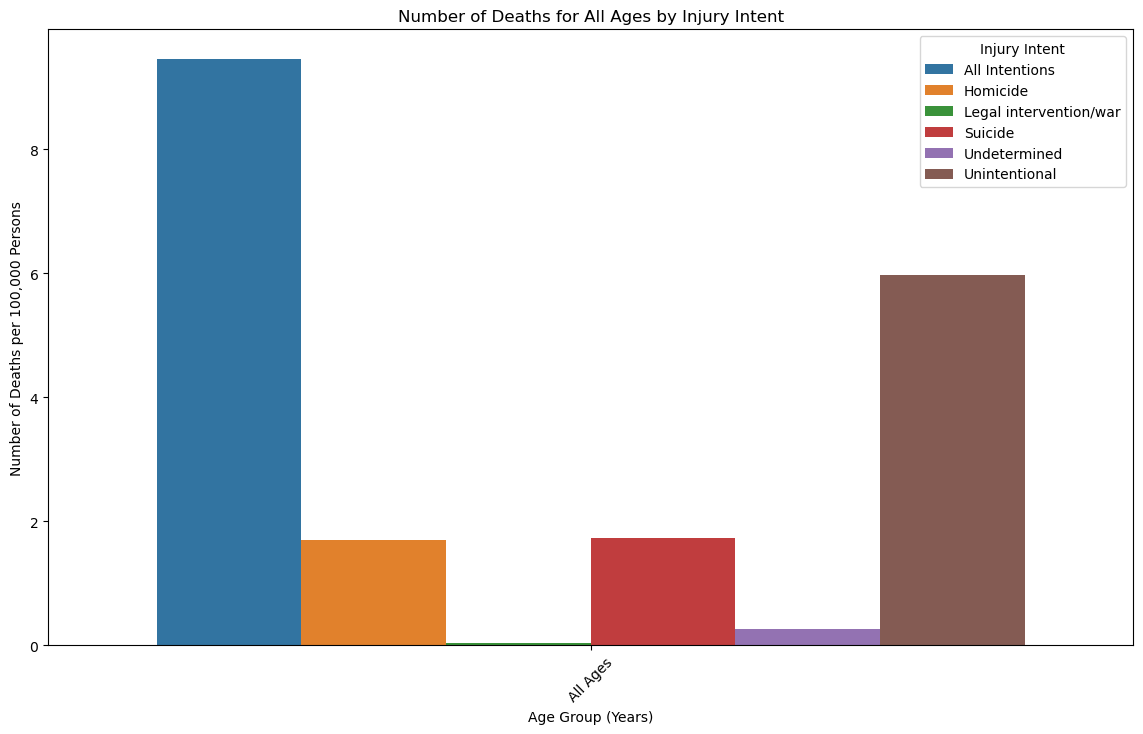

In [29]:
# Separate the data for All Ages and other age groups
all_ages_data = age_group_summary[age_group_summary['Age Group (Years)'] == 'All Ages']
other_age_groups_data = age_group_summary[age_group_summary['Age Group (Years)'] != 'All Ages']

# Plotting a bar chart for All Ages (Injury Intent)
plt.figure(figsize=(14, 8))
sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Intent', data=all_ages_data, ci = None)
plt.title('Number of Deaths for All Ages by Injury Intent')
plt.xlabel('Age Group (Years)')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Intent')
plt.xticks(rotation=45)
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\1203617914.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Intent', data=other_age_groups_data, ci = None)


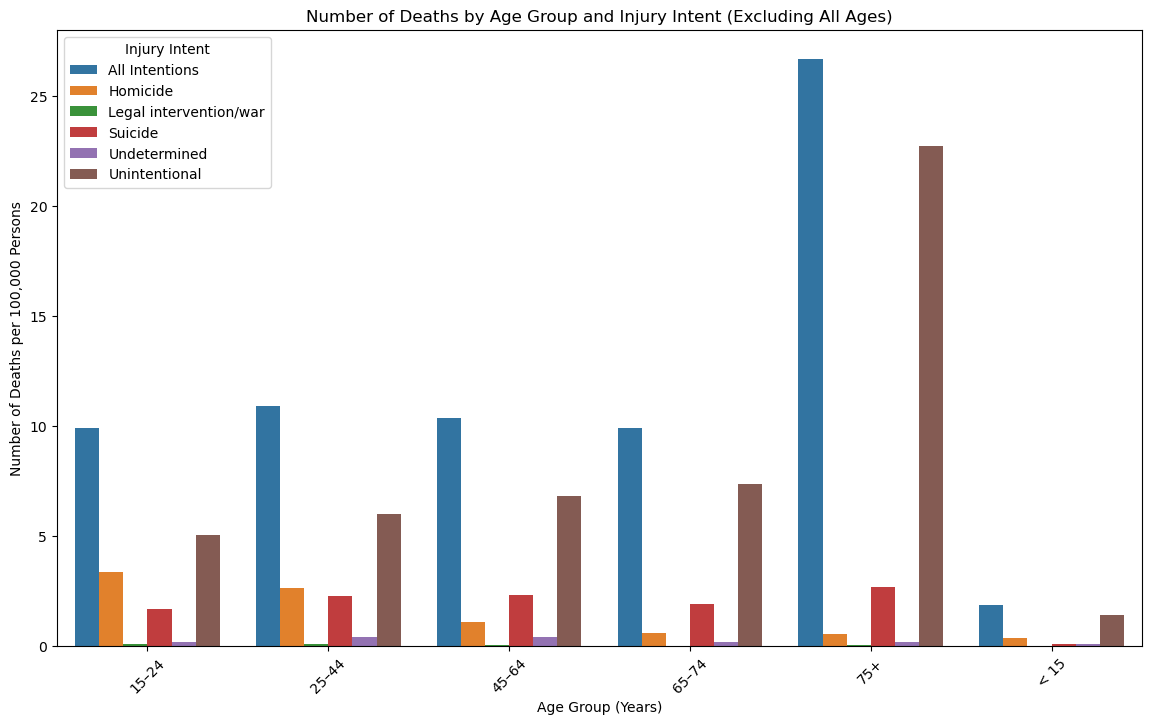

In [30]:
# Plotting a bar chart for other age groups (Injury Intent)
plt.figure(figsize=(14, 8))
sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Intent', data=other_age_groups_data, ci = None)
plt.title('Number of Deaths by Age Group and Injury Intent (Excluding All Ages)')
plt.xlabel('Age Group (Years)')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Intent')
plt.xticks(rotation=45)
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\3204018536.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Mechanism', data=all_ages_data, ci=None)


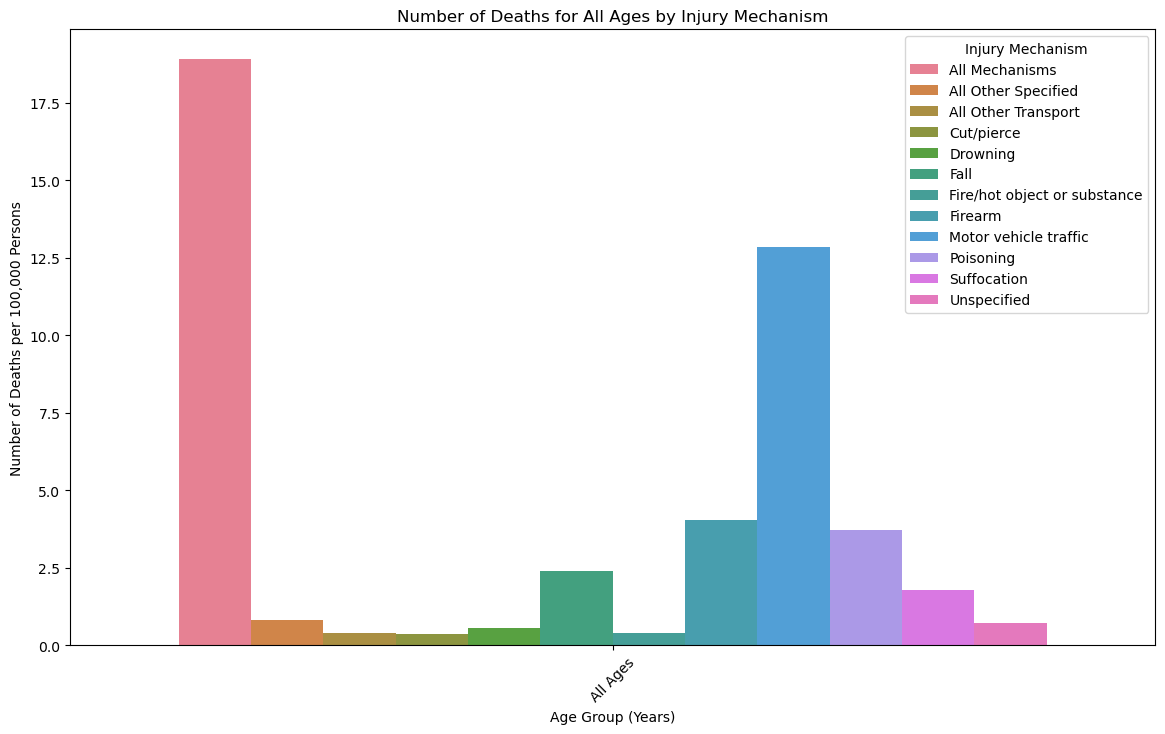

In [31]:
# Plotting a bar chart for All Ages (Injury Mechanism)
plt.figure(figsize=(14, 8))
sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Mechanism', data=all_ages_data, ci=None)
plt.title('Number of Deaths for All Ages by Injury Mechanism')
plt.xlabel('Age Group (Years)')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Mechanism')
plt.xticks(rotation=45)
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2251789846.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Mechanism', data=other_age_groups_data, ci=None)


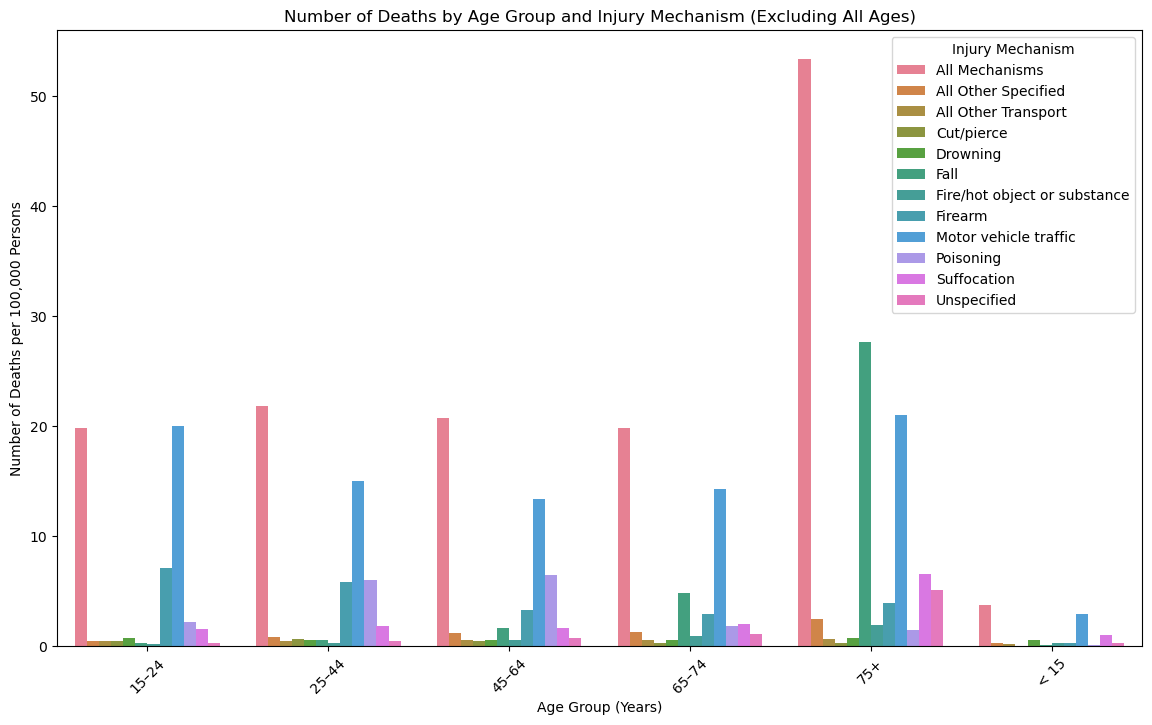

In [32]:
# Plotting a bar chart for other age groups (Injury Mechanism)
plt.figure(figsize=(14, 8))
sns.barplot(x='Age Group (Years)', y='Age Specific Rate', hue='Injury Mechanism', data=other_age_groups_data, ci=None)
plt.title('Number of Deaths by Age Group and Injury Mechanism (Excluding All Ages)')
plt.xlabel('Age Group (Years)')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Mechanism')
plt.xticks(rotation=45)
plt.show()

In [33]:
# Summarize data group by Sex, Injury Intent and Injury Mechanism
sex_summary = df.groupby(['Sex', 'Injury Intent', 'Injury Mechanism']).agg({
    'Deaths': 'sum',
    'Population': 'sum',
    'Age Specific Rate': 'mean'
}).reset_index()

# Display the summary
sex_summary

,Sex,Injury Intent,Injury Mechanism,Deaths,Population,Age Specific Rate
0,Both sexes,All Intentions,All Mechanisms,12710328,21108613556,66.517215
1,Both sexes,All Intentions,All Other Specified,525655,21108613556,3.022355
2,Both sexes,All Intentions,All Other Transport,296655,21108613556,1.301386
3,Both sexes,All Intentions,Cut/pierce,185275,21108613556,1.049019
4,Both sexes,All Intentions,Drowning,290901,21108613556,1.420012
...,...,...,...,...,...,...
190,Male,Unintentional,Firearm,39209,10382252836,0.393050
191,Male,Unintentional,Motor vehicle traffic,1911645,10382252836,20.331355
192,Male,Unintentional,Poisoning,1394133,10382252836,9.906576
193,Male,Unintentional,Suffocation,240403,10382252836,4.126832


C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\3384511563.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Age Specific Rate', hue='Injury Intent', data=sex_summary, ci = None)


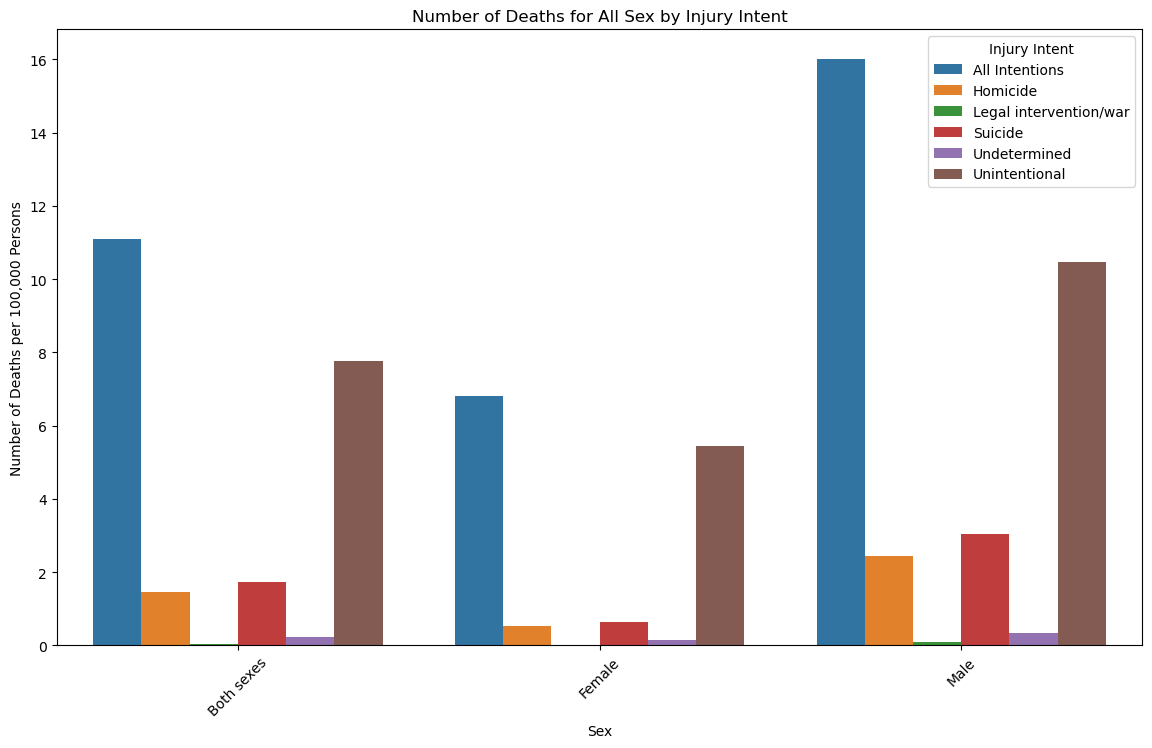

In [34]:
# Plotting a bar chart for Sex (Injury Intent)
plt.figure(figsize=(14, 8))
sns.barplot(x='Sex', y='Age Specific Rate', hue='Injury Intent', data=sex_summary, ci = None)
plt.title('Number of Deaths for All Sex by Injury Intent')
plt.xlabel('Sex')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Intent')
plt.xticks(rotation=45)
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\706227853.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Sex', y='Age Specific Rate', hue='Injury Mechanism', data=sex_summary, ci = None)


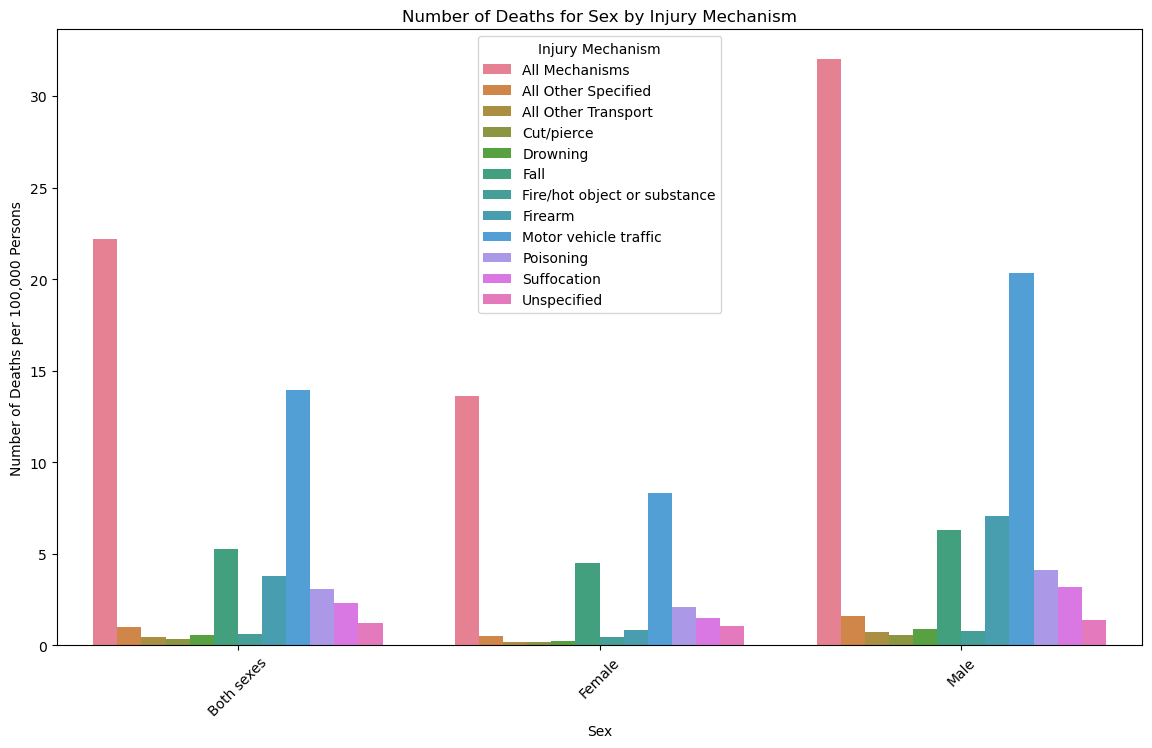

In [35]:
# Plotting a bar chart for Sex (Injury Mechanism)
plt.figure(figsize=(14, 8))
sns.barplot(x='Sex', y='Age Specific Rate', hue='Injury Mechanism', data=sex_summary, ci = None)
plt.title('Number of Deaths for Sex by Injury Mechanism')
plt.xlabel('Sex')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Mechanism')
plt.xticks(rotation=45)
plt.show()

In [36]:
# Summarize data group by Race, Injury Intent and Injury Mechanism
race_summary = df.groupby(['Race', 'Injury Intent', 'Injury Mechanism']).agg({
    'Deaths': 'sum',
    'Population': 'sum',
    'Age Specific Rate': 'mean'
}).reset_index()

# Display the summary
race_summary

,Race,Injury Intent,Injury Mechanism,Deaths,Population,Age Specific Rate
0,All races,All Intentions,All Mechanisms,12945110,21742985836,72.595250
1,All races,All Intentions,All Other Specified,537464,21742985836,3.044215
2,All races,All Intentions,All Other Transport,303418,21742985836,1.517761
3,All races,All Intentions,Cut/pierce,190790,21742985836,0.839591
4,All races,All Intentions,Drowning,301098,21742985836,1.451513
...,...,...,...,...,...,...
255,Non-Hispanic white,Unintentional,Firearm,31850,14361869320,0.227286
256,Non-Hispanic white,Unintentional,Motor vehicle traffic,1958410,14361869320,14.831091
257,Non-Hispanic white,Unintentional,Poisoning,1659958,14361869320,9.104280
258,Non-Hispanic white,Unintentional,Suffocation,333592,14361869320,3.594411


C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\4106650.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Race', y='Age Specific Rate', hue='Injury Intent', data=race_summary, ci = None)


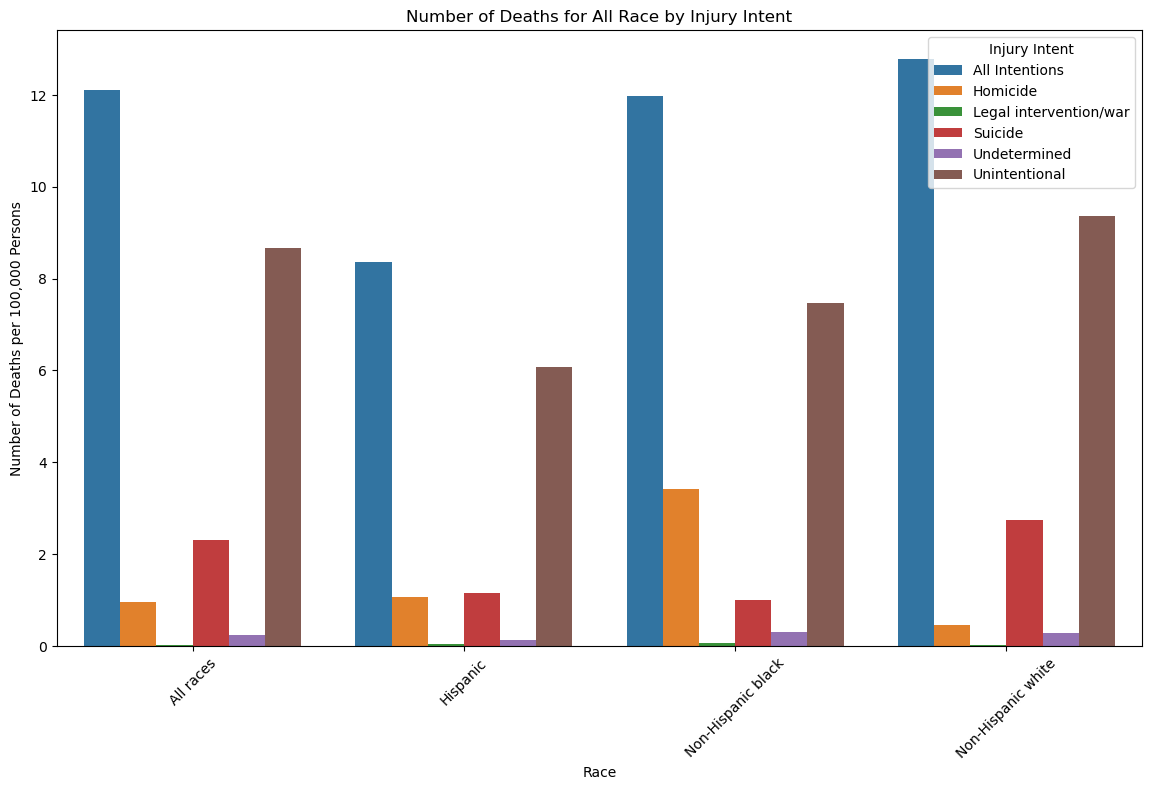

In [37]:
# Plotting a bar chart for Race (Injury Intent)
plt.figure(figsize=(14, 8))
sns.barplot(x='Race', y='Age Specific Rate', hue='Injury Intent', data=race_summary, ci = None)
plt.title('Number of Deaths for All Race by Injury Intent')
plt.xlabel('Race')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Intent')
plt.xticks(rotation=45)
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\3747234727.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Race', y='Age Specific Rate', hue='Injury Mechanism', data=race_summary, ci = None)


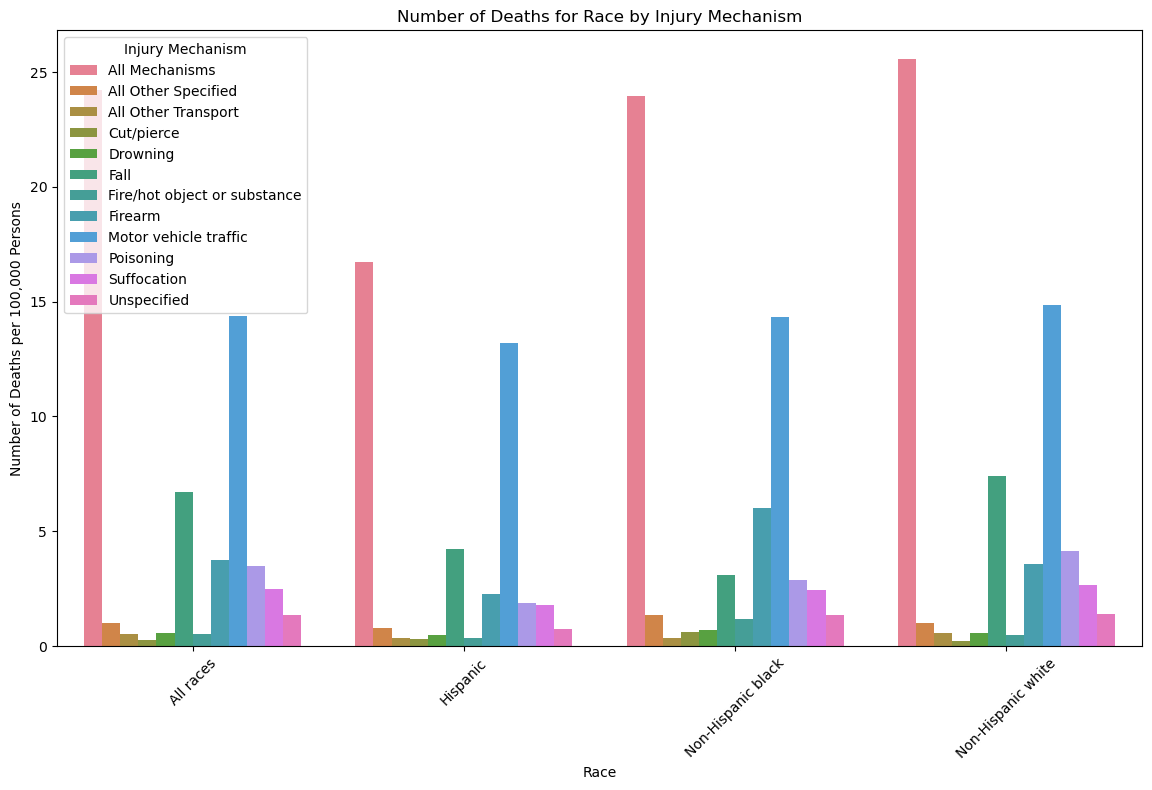

In [38]:
# Plotting a bar chart for Race (Injury Mechanism)
plt.figure(figsize=(14, 8))
sns.barplot(x='Race', y='Age Specific Rate', hue='Injury Mechanism', data=race_summary, ci = None)
plt.title('Number of Deaths for Race by Injury Mechanism')
plt.xlabel('Race')
plt.ylabel('Number of Deaths per 100,000 Persons')
plt.legend(title='Injury Mechanism')
plt.xticks(rotation=45)
plt.show()

In [39]:
# Statistical Summary
df.describe()

,Year,Deaths,Population,Age Specific Rate,Age Specific Rate Standard Error,Age Specific Rate Lower Confidence Limit,Age Specific Rate Upper Confidence Limit
count,98280.000000,98280.000000,9.828000e+04,98280.000000,80093.000000,98280.000000,98280.000000
mean,2007.500000,1030.300346,2.792145e+07,4.144323,0.178736,3.872784,4.461783
std,5.188154,5654.431217,4.615604e+07,14.839778,0.385711,14.386794,15.305750
min,1999.000000,0.000000,2.381630e+05,0.000000,0.000311,0.000000,0.000000
25%,2003.000000,2.000000,4.841440e+06,0.018200,0.022286,0.002576,0.050011
50%,2007.500000,26.000000,1.204773e+07,0.244084,0.061702,0.145650,0.396250
75%,2012.000000,235.000000,2.956510e+07,1.828186,0.169559,1.546272,2.166448
max,2016.000000,231991.000000,3.231275e+08,283.918310,8.270687,279.858790,287.977830


In [40]:
# Drop rows contain All Intentions, All Mechanisms, All races, Both sexes and All Ages 
df_no_all = df[
    (df['Injury Intent'] != 'All Intentions') &
    (df['Injury Mechanism'] != 'All Mechanisms') &
    (df['Race'] != 'All races') &
    (df['Sex'] != 'Both sexes') &
    (df['Age Group (Years)'] != 'All Ages')
]

In [41]:
df_no_all.head()

,Year,Sex,Age Group (Years),Race,Injury Mechanism,Injury Intent,Deaths,Population,Age Specific Rate,Age Specific Rate Standard Error,Age Specific Rate Lower Confidence Limit,Age Specific Rate Upper Confidence Limit,Age Adjusted Rate,Age Adjusted Rate Standard Error,Age Adjusted Rate Lower Confidence Limit,Age Adjusted Rate Upper Confidence Limit
557,2000,Female,< 15,Hispanic,Cut/pierce,Unintentional,0,5135565,0.0,NaN,0.0,0.0,,,,
691,1999,Female,< 15,Hispanic,Cut/pierce,Unintentional,0,4945811,0.0,NaN,0.0,0.0,,,,
888,2010,Female,75+,Hispanic,Cut/pierce,Unintentional,0,685688,0.0,NaN,0.0,0.0,,,,
2253,2011,Female,< 15,Hispanic,Cut/pierce,Suicide,0,7211562,0.0,NaN,0.0,0.0,,,,
2319,2010,Female,< 15,Hispanic,Cut/pierce,Suicide,0,7066167,0.0,NaN,0.0,0.0,,,,


In [42]:
df_no_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31104 entries, 557 to 98279
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Year                                      31104 non-null  int64  
 1   Sex                                       31104 non-null  object 
 2   Age Group (Years)                         31104 non-null  object 
 3   Race                                      31104 non-null  object 
 4   Injury Mechanism                          31104 non-null  object 
 5   Injury Intent                             31104 non-null  object 
 6   Deaths                                    31104 non-null  int64  
 7   Population                                31104 non-null  int64  
 8   Age Specific Rate                         31104 non-null  float64
 9   Age Specific Rate Standard Error          21099 non-null  float64
 10  Age Specific Rate Lower Confidence Li

In [43]:
df_no_all.describe()

,Year,Deaths,Population,Age Specific Rate,Age Specific Rate Standard Error,Age Specific Rate Lower Confidence Limit,Age Specific Rate Upper Confidence Limit
count,31104.000000,31104.000000,3.110400e+04,31104.000000,21099.000000,31104.000000,31104.000000
mean,2007.500000,98.567998,7.899013e+06,1.392132,0.168792,1.191113,1.671321
std,5.188211,513.520761,7.943975e+06,5.863699,0.318594,5.511512,6.247619
min,1999.000000,0.000000,2.381630e+05,0.000000,0.003323,0.000000,0.000000
25%,2003.000000,0.000000,2.956416e+06,0.000000,0.028692,0.000000,0.000000
50%,2007.500000,3.000000,5.069592e+06,0.068020,0.067066,0.014085,0.172766
75%,2012.000000,25.000000,9.284036e+06,0.470065,0.168375,0.274439,0.845366
max,2016.000000,15446.000000,3.009173e+07,146.227520,4.522251,143.314180,149.140870


In [44]:
# Select only numerical data
num_df = df_no_all.select_dtypes(include=['number'])

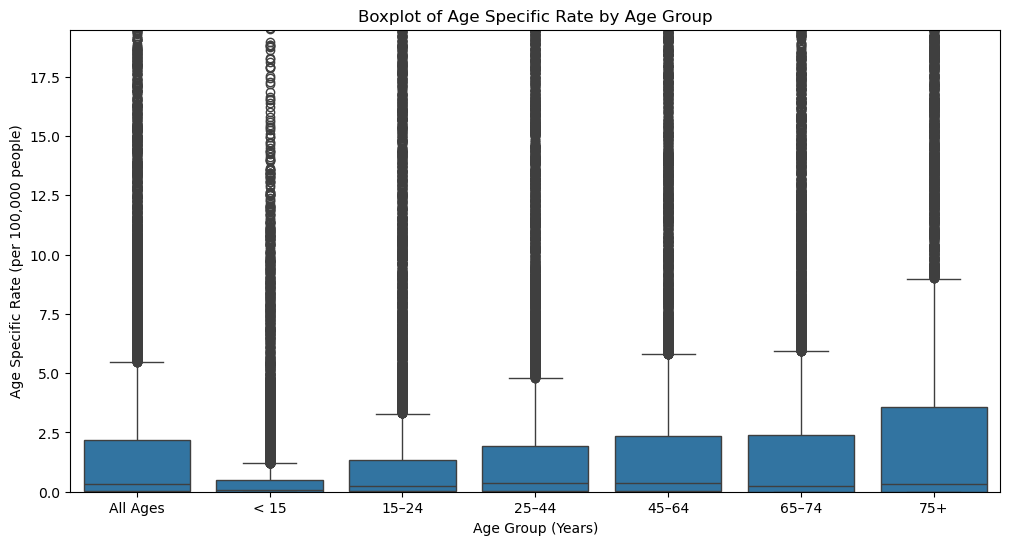

In [45]:
# Boxplots using Age Specific Rate for Age Group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age Group (Years)', y='Age Specific Rate', data=df)
plt.title('Boxplot of Age Specific Rate by Age Group')
plt.xlabel('Age Group (Years)')
plt.ylabel('Age Specific Rate (per 100,000 people)')

# Adjust the y-axis limit to make the boxplot more readable
plt.ylim(0, df['Age Specific Rate'].quantile(0.95))

plt.show()

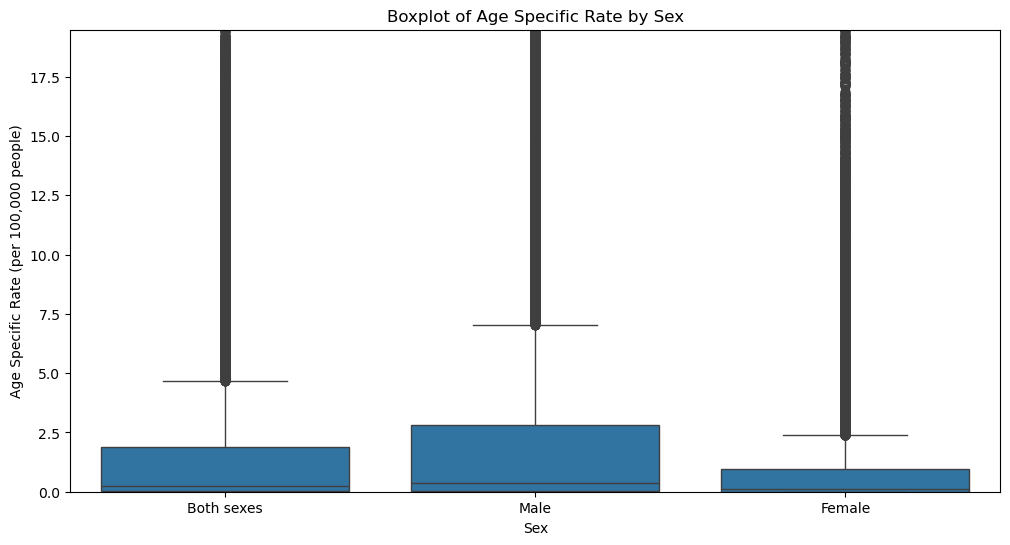

In [46]:
# Boxplots using Age Specific Rate for Sex
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sex', y='Age Specific Rate', data=df)
plt.title('Boxplot of Age Specific Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Age Specific Rate (per 100,000 people)')

# Adjust the y-axis limit to make the boxplot more readable
plt.ylim(0, df['Age Specific Rate'].quantile(0.95))

plt.show()

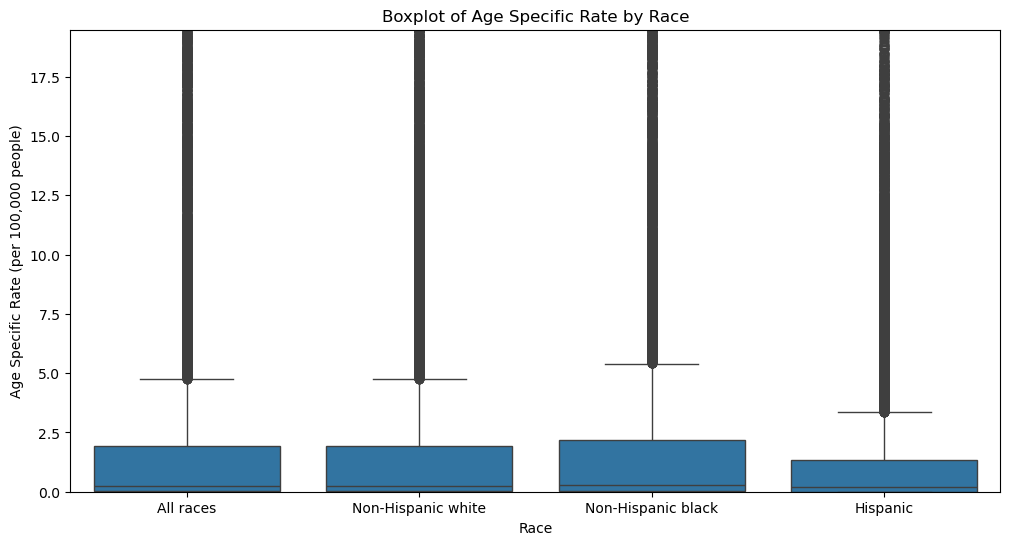

In [47]:
# Boxplots using Age Specific Rate for Race
plt.figure(figsize=(12, 6))
sns.boxplot(x='Race', y='Age Specific Rate', data=df)
plt.title('Boxplot of Age Specific Rate by Race')
plt.xlabel('Race')
plt.ylabel('Age Specific Rate (per 100,000 people)')

# Adjust the y-axis limit to make the boxplot more readable
plt.ylim(0, df['Age Specific Rate'].quantile(0.95))

plt.show()

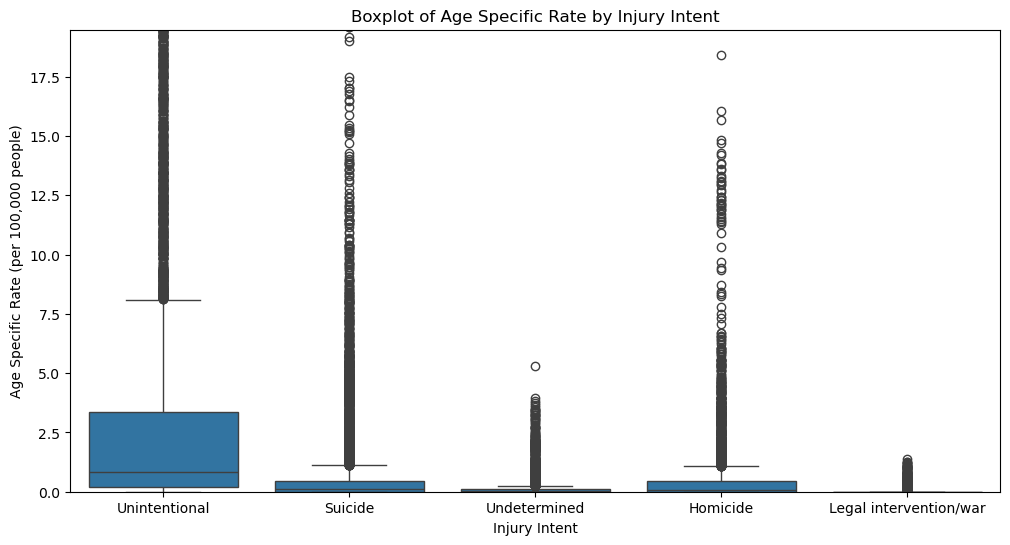

In [48]:
# Boxplots using Age Specific Rate for Injury Intent
plt.figure(figsize=(12, 6))
sns.boxplot(x='Injury Intent', y='Age Specific Rate', data=df_no_all)
plt.title('Boxplot of Age Specific Rate by Injury Intent')
plt.xlabel('Injury Intent')
plt.ylabel('Age Specific Rate (per 100,000 people)')

# Adjust the y-axis limit to make the boxplot more readable
plt.ylim(0, df['Age Specific Rate'].quantile(0.95))

plt.show()

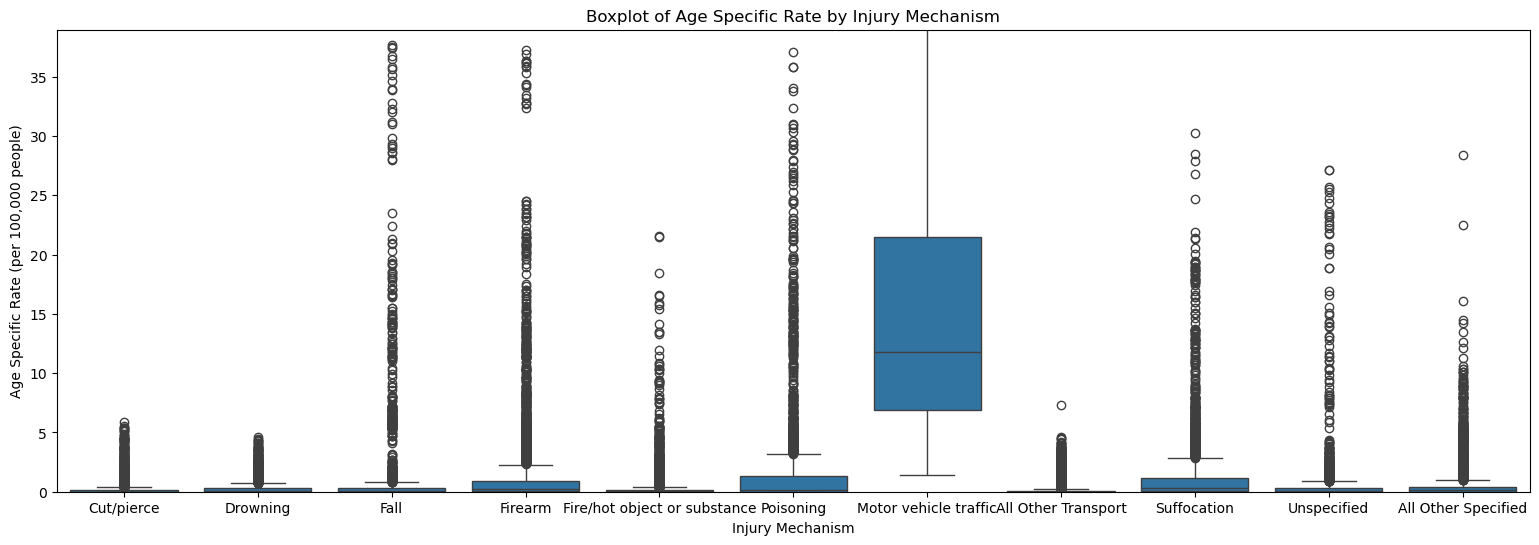

In [49]:
# Boxplots using Age Specific Rate for Injury Mechanism
plt.figure(figsize=(19, 6))
sns.boxplot(x='Injury Mechanism', y='Age Specific Rate', data=df_no_all)
plt.title('Boxplot of Age Specific Rate by Injury Mechanism')
plt.xlabel('Injury Mechanism')
plt.ylabel('Age Specific Rate (per 100,000 people)')

# Adjust the y-axis limit to a specific value
upper_limit = df['Age Specific Rate'].quantile(0.95) * 2.0  # Adding a 10% buffer
plt.ylim(0, upper_limit)

plt.show()

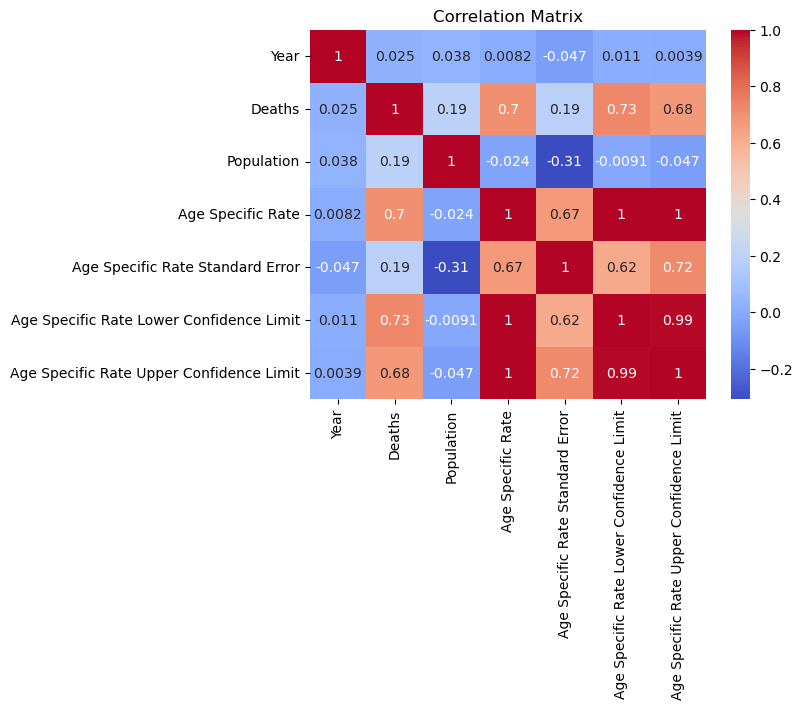

In [50]:
# Correlation matrix
correlation_matrix = num_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

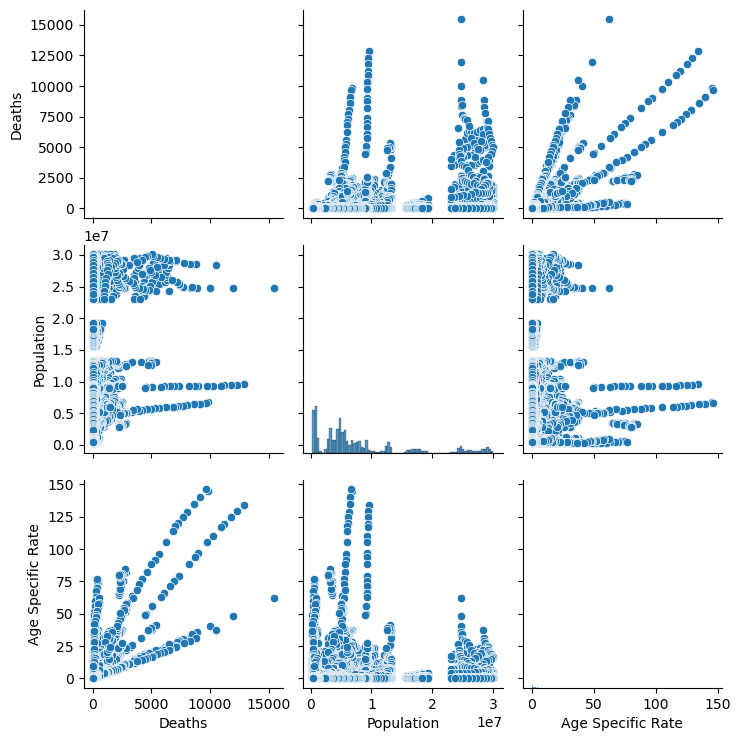

In [51]:
# Select specific numerical columns
selected_columns = ['Deaths', 'Population', 'Age Specific Rate']
num_df = num_df[selected_columns]

# Create pair plot
sns.pairplot(num_df)
plt.show()

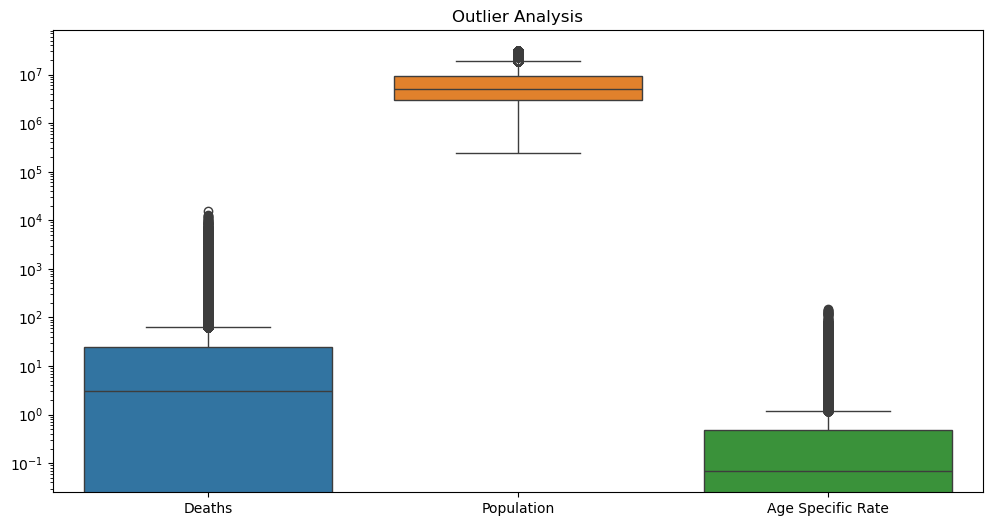

In [52]:
# Outlier analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=num_df[['Deaths', 'Population', 'Age Specific Rate']])
plt.title('Outlier Analysis')
plt.yscale('log')  # Use logarithmic scale for better visibility
plt.show()

## Plan for clustering
1. Analyze patterns in injury deaths across different demographic groups (age, sex, race).
2. Examine temporal trends in injury deaths from 1999 to 2016.
3. Identify clusters of injury mechanisms and intents that frequently occur together.rates.

## Clustering algorithms
1. Hierarchical clustering: Useful for exploring relationships between injury mechanisms and intents. 
Can reveal hierarchical structures in the data, which may be valuable for understanding injury categorization
2. KMeans: Good for large dataset. Can identify cluster of trend.
3. FCM: Examining relationships between injury mechanisms and intents. Allow data points to belong to multiple clusters simultaneously, which can be beneficial when dealing with overlapping injury categories.a.s.s.

In [53]:
# Drop rows contain All Intentions, All Mechanisms, All Ages
age_group_summary = age_group_summary[
    (age_group_summary['Injury Intent'] != 'All Intentions') &
    (age_group_summary['Injury Mechanism'] != 'All Mechanisms') &
    (age_group_summary['Age Group (Years)'] != 'All Ages')
]

age_group_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 13 to 389
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age Group (Years)  288 non-null    object 
 1   Injury Intent      288 non-null    object 
 2   Injury Mechanism   288 non-null    object 
 3   Deaths             288 non-null    int64  
 4   Population         288 non-null    int64  
 5   Age Specific Rate  288 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 15.8+ KB


In [54]:
# Drop rows contain All Intentions, All Mechanisms, All races
race_summary = race_summary[
    (race_summary['Injury Intent'] != 'All Intentions') &
    (race_summary['Injury Mechanism'] != 'All Mechanisms') &
    (race_summary['Race'] != 'All races')
]

race_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 78 to 259
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Race               144 non-null    object 
 1   Injury Intent      144 non-null    object 
 2   Injury Mechanism   144 non-null    object 
 3   Deaths             144 non-null    int64  
 4   Population         144 non-null    int64  
 5   Age Specific Rate  144 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 7.9+ KB


In [55]:
# Drop rows contain All Intentions, All Mechanisms, Both Sexes
sex_summary = sex_summary[
    (sex_summary['Injury Intent'] != 'All Intentions') &
    (sex_summary['Injury Mechanism'] != 'All Mechanisms') &
    (sex_summary['Sex'] != 'Both sexes')
]

sex_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 78 to 194
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex                96 non-null     object 
 1   Injury Intent      96 non-null     object 
 2   Injury Mechanism   96 non-null     object 
 3   Deaths             96 non-null     int64  
 4   Population         96 non-null     int64  
 5   Age Specific Rate  96 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.2+ KB


In [56]:
# Standardized data
def scale_numerical(df, num_columns):
    scaler = StandardScaler()
    df[num_columns] = scaler.fit_transform(df[num_columns])
    return df

age_summary_scaled = scale_numerical(age_group_summary, ['Deaths', 'Population', 'Age Specific Rate'])
race_summary_scaled = scale_numerical(race_summary, ['Deaths', 'Population', 'Age Specific Rate'])
sex_summary_scaled = scale_numerical(sex_summary, ['Deaths', 'Population', 'Age Specific Rate'])

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2008236810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_columns] = scaler.fit_transform(df[num_columns])
C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2008236810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_columns] = scaler.fit_transform(df[num_columns])
C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2008236810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### 1. Hierarchical Clustering

In [57]:
# Select numerical data from scaled data
numerical_columns = ['Deaths', 'Population', 'Age Specific Rate']
X_age = age_summary_scaled[numerical_columns]
X_race = race_summary_scaled[numerical_columns]
X_sex = sex_summary_scaled[numerical_columns]

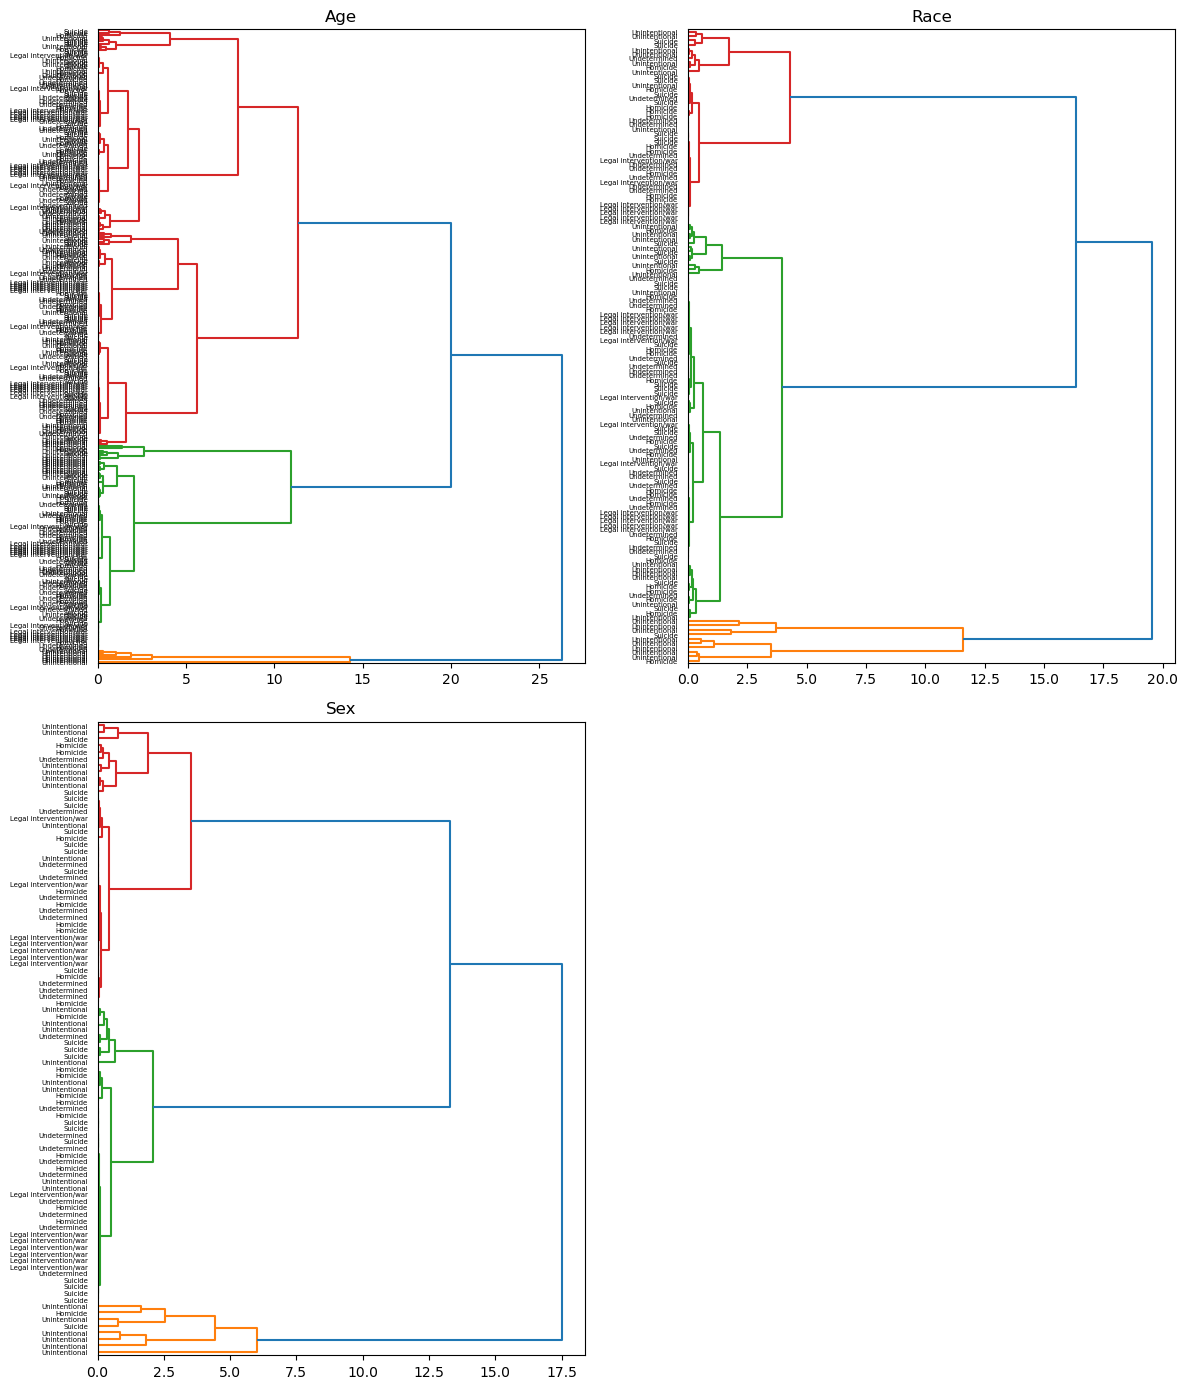

In [58]:
# Fit linkage
Z1 = linkage(X_age, method='ward')
Z2 = linkage(X_race, method='ward')
Z3 = linkage(X_sex, method='ward')

# Extract labels and convert to list
labels_age = age_summary_scaled['Injury Intent'].tolist()
labels_race = race_summary_scaled['Injury Intent'].tolist()
labels_sex = sex_summary_scaled['Injury Intent'].tolist()

# Plot dendrogram with labels
plt.figure(figsize=(12, 14))
plt.subplot(2,2,1)
dendrogram(Z1, labels=labels_age, orientation='right')
plt.title('Age')

plt.subplot(2,2,2)
dendrogram(Z2, labels=labels_race, orientation='right')
plt.title('Race')

plt.subplot(2,2,3)
dendrogram(Z3, labels=labels_sex, orientation='right')
plt.title('Sex')

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

In [59]:
# Fit hierarchical clustering
n_clusters = 4  # Based on the dendrogram
hc_age = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_race = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_sex = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

age_summary_scaled['Cluster_hc'] = hc_age.fit_predict(X_age)
race_summary_scaled['Cluster_hc'] = hc_race.fit_predict(X_race)
sex_summary_scaled['Cluster_hc'] = hc_sex.fit_predict(X_sex)

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\117471650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_summary_scaled['Cluster_hc'] = hc_age.fit_predict(X_age)
C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\117471650.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_summary_scaled['Cluster_hc'] = hc_race.fit_predict(X_race)
C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\117471650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

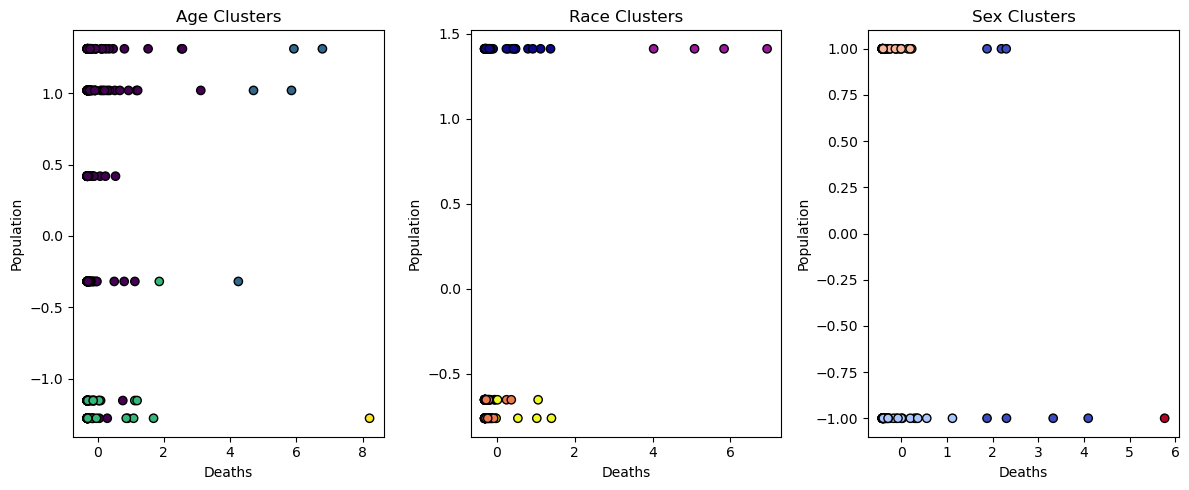

In [60]:
# 2D Cluster Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_age['Deaths'], X_age['Population'], c=age_summary_scaled['Cluster_hc'], cmap='viridis', edgecolors='k')
plt.xlabel('Deaths')
plt.ylabel('Population')
plt.title('Age Clusters')

plt.subplot(1, 3, 2)
plt.scatter(X_race['Deaths'], X_race['Population'], c=race_summary_scaled['Cluster_hc'], cmap='plasma', edgecolors='k')
plt.xlabel('Deaths')
plt.ylabel('Population')
plt.title('Race Clusters')

plt.subplot(1, 3, 3)
plt.scatter(X_sex['Deaths'], X_sex['Population'], c=sex_summary_scaled['Cluster_hc'], cmap='coolwarm', edgecolors='k')
plt.xlabel('Deaths')
plt.ylabel('Population')
plt.title('Sex Clusters')

plt.tight_layout()
plt.show()

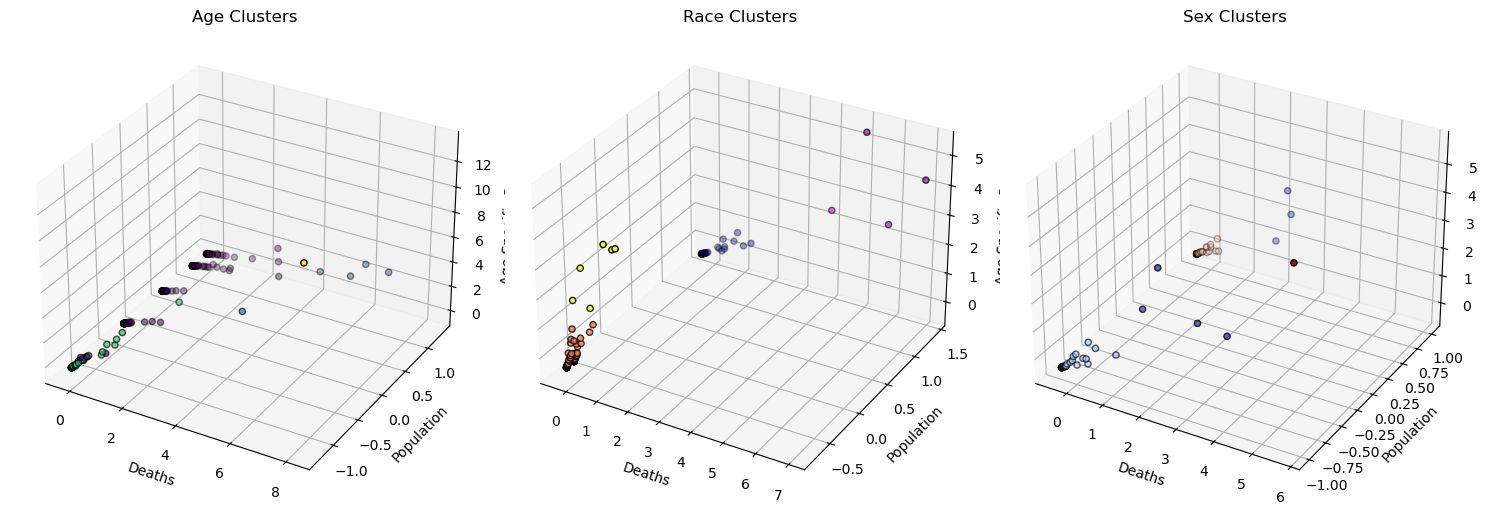

In [61]:
# 3D Cluster Plot
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_age['Deaths'], X_age['Population'], X_age['Age Specific Rate'], c=age_summary_scaled['Cluster_hc'], cmap='viridis', edgecolors='k')
ax1.set_xlabel('Deaths')
ax1.set_ylabel('Population')
ax1.set_zlabel('Age Specific Rate')
ax1.set_title('Age Clusters')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_race['Deaths'], X_race['Population'], X_race['Age Specific Rate'], c=race_summary_scaled['Cluster_hc'], cmap='plasma', edgecolors='k')
ax2.set_xlabel('Deaths')
ax2.set_ylabel('Population')
ax2.set_zlabel('Age Specific Rate')
ax2.set_title('Race Clusters')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_sex['Deaths'], X_sex['Population'], X_sex['Age Specific Rate'], c=sex_summary_scaled['Cluster_hc'], cmap='coolwarm', edgecolors='k')
ax3.set_xlabel('Deaths')
ax3.set_ylabel('Population')
ax3.set_zlabel('Age Specific Rate')
ax3.set_title('Sex Clusters')

plt.tight_layout()
plt.show()

- For Age Cluster, there seem to be high population high death (blue), high population low death (purple), low population low death (green), and low population high death groups (yellow). Considering the EDA we did before and the bias/fairness boxplot below, it's likely that high population low death is the middle age group and low population low death is the younger group. The high death groups are likely to be old people.
- For Race Cluster, there seem to be low death low population (orange), low population medium death (yellow), high population low death (blue), and high population high death (purple). Considering the EDA we did before and the bias/fairness boxplot below, it's likely that the high population high death is the non-hispanic white.
- For Sex Cluster, there seem to be high population high death (pink), low population low death (light blue), medium death (blue), low population high death (red). Considering the EDA we did before and the bias/fairness boxplot below, it's likely that the high to medium death are male since they have higher death rate than female.

- Quality of Age Cluster appears somewhat distinct, but there's also some overlap for the clusters at the top (high population) and those at the bottom (low population), and one distinct outlier cluster (yellow).
- Quality of Race Cluster shows very tight clustering along the population axis, but less distinct separation along the deaths axis. This suggests the algorithm identifies distinct racial groups in terms of population size, but injury death patterns are less well-defined.
- Quality of Sex Cluster is somewhat distinct although there is an outlier cluster (red).

### 2. K-means

In [62]:
# Calculate Death Rate
time_series = df_no_all.groupby('Year').agg({'Deaths': 'sum', 'Population': 'first'}).reset_index()
time_series['DeathRate'] = time_series['Deaths'] / time_series['Population']

# Standardized data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(time_series[['Year', 'DeathRate']])
scaled_df = pd.DataFrame(scaled_features, columns=['Year_Scaled', 'DeathRate_Scaled'])

In [63]:
scaled_df.head()

,Year_Scaled,DeathRate_Scaled
0,-1.638356,-0.607893
1,-1.445608,-0.617985
2,-1.252861,-0.628376
3,-1.060113,-0.629258
4,-0.867365,-0.341033


C:\Users\Apits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Apits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Apits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Apits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

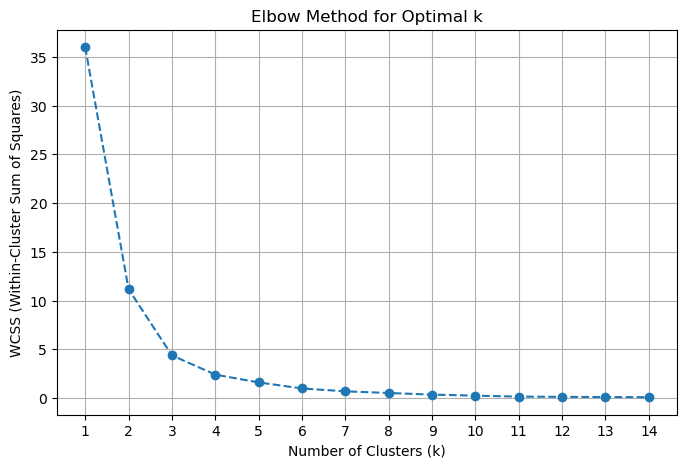

In [64]:
# Compute WCSS for different k values
wcss = []
K_range = range(1, 15)  # Try k values from 1 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # Inertia = sum of squared distances to closest centroid

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.xticks(K_range)
plt.grid(True)
plt.show()

C:\Users\Apits\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


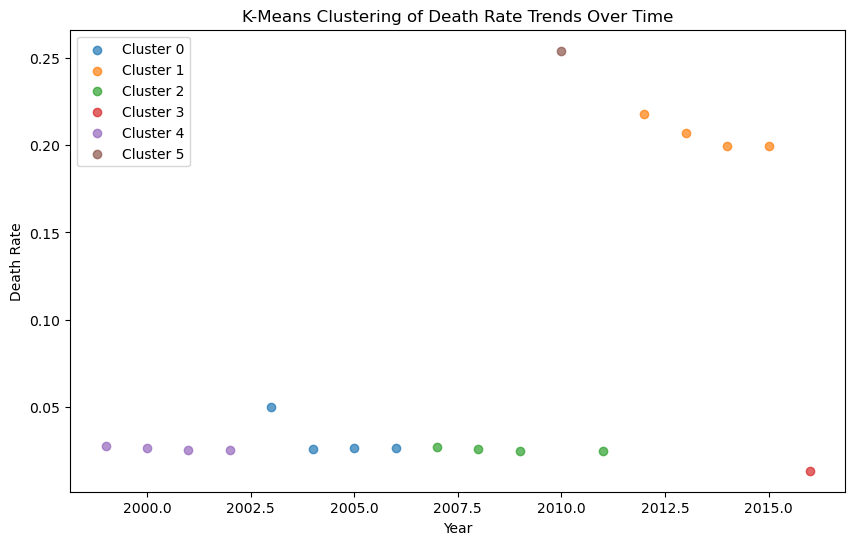

In [65]:
k = 6 # Based on the elbow method result
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
time_series['Cluster'] = kmeans.fit_predict(scaled_features)

# 2D Scatter Plot of Clusters
plt.figure(figsize=(10, 6))
for cluster in range(k):
    subset = time_series[time_series['Cluster'] == cluster]
    plt.scatter(subset['Year'], subset['DeathRate'], label=f"Cluster {cluster}", alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Death Rate")
plt.title("K-Means Clustering of Death Rate Trends Over Time")
plt.legend()
plt.show()

- Cluster 0 (Purple): This cluster seems to group years with a consistently low death rate (around 0.02-0.03). These are primarily the earlier years in the dataset (1999-2002).
- Cluster 1 (Blue): This seems to capture the death rates that are slightly higher than the "low" group. These data points occur at 2003 and 2004.
- Cluster 2 (Green): These data points correspond to death rates of around 0.03, appearing in the years 2007-2011.
- Cluster 3 (Brown): This cluster consists of a single outlier, with death rate of 0.25 in the year 2010
- Cluster 4 (Orange): This seems like another outlier or high death rate group, which occurs in 2012-2015 with a death rate around 0.20-0.23.
- Cluster 5 (Red): These data points correspond to very low death rates, appearing in the 2016. 

Quality of the clusters representing years with similar death rates shows varying degrees of separation. Cluster 0 (Purple) and Cluster 2 (Green) appear relatively distinct, grouping years with consistently low death rates. However, there is some temporal overlap between these two clusters, suggesting that the transition between them might not be sharply defined. Clusters 3 (Brown) and 4 (Orange) are outliers and, by definition, distinct. Clusters 5 (Red) and 1 (Blue) also appear somewhat distinct. Overall, the clusters demonstrate some ability to capture different phases in the trend, but the presence of temporal overlap and outliers suggests that the underlying patterns might be more complex than what K-means can fully capture with the given parameters.

## 3. FCM

In [104]:
# Load data
categorical_data = df_no_all[['Injury Intent', 'Injury Mechanism']]
numerical_data = df_no_all[['Deaths', 'Population']]

# One-Hot Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(categorical_data)

# Standardize numerical features
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(numerical_data)

# Combine numerical and categorical data
combined_data = np.concatenate([numerical_scaled, categorical_encoded], axis=1)

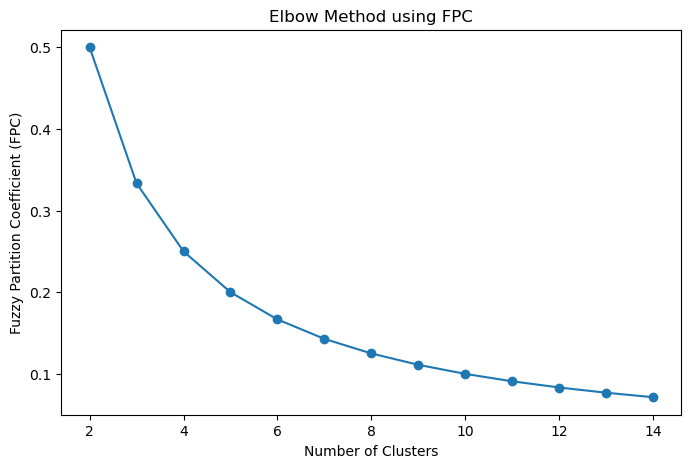

In [105]:
# Try different numbers of clusters
n_clusters_range = range(2, 15)
fpc_values = []

for n in n_clusters_range:
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        combined_data.T, n, 2, error=0.005, maxiter=1000
    )
    fpc_values.append(fpc)

# Plot the FPC values
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, fpc_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Fuzzy Partition Coefficient (FPC)")
plt.title("Elbow Method using FPC")
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2009022003.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_all['FCM_Cluster'] = labels


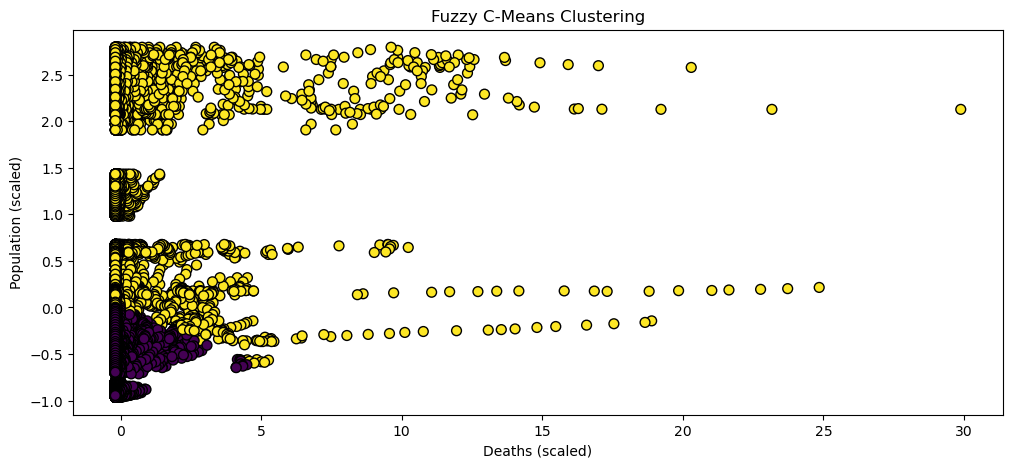

[[0.5001428  0.50015053 0.50025714 ... 0.50024294 0.50024329 0.50024349]
 [0.4998572  0.49984947 0.49974286 ... 0.49975706 0.49975671 0.49975651]]


In [106]:
# Apply Fuzzy C-Means clustering on the combined data
n_clusters = 2  # You can adjust the number of clusters
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(combined_data.T, n_clusters, 2, error=0.005, maxiter=1000)

# Assign each sample to the cluster with the highest membership degree
labels = np.argmax(u, axis=0)

# Add clustering results to your DataFrame
df_no_all['FCM_Cluster'] = labels

# Plot the fuzzy C-Means results
plt.figure(figsize=(12, 5))
plt.scatter(numerical_scaled[:, 0], numerical_scaled[:, 1], c=labels, cmap='viridis', edgecolors='k', s=50)
plt.title('Fuzzy C-Means Clustering')
plt.xlabel('Deaths (scaled)')
plt.ylabel('Population (scaled)')
plt.show()

# Print the fuzzy membership values (how much each point belongs to each cluster)
print(u)

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\292942004.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_all['FCM_Cluster'] = labels


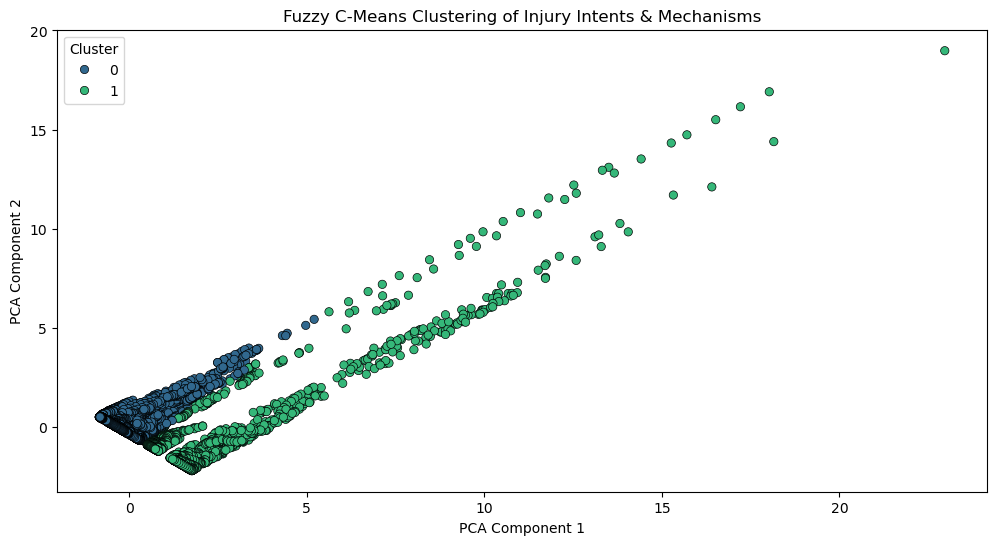

[[9.99125279e-01 9.99632237e-01 9.71364136e-01 ... 9.69929252e-01
  9.69563897e-01 9.69339414e-01]
 [8.74721383e-04 3.67763082e-04 2.86358639e-02 ... 3.00707477e-02
  3.04361029e-02 3.06605858e-02]]


In [107]:
# Reduce dimensions using PCA for better clustering
pca = PCA(n_components=2)  # Adjust based on variance explained
combined_data_pca = pca.fit_transform(combined_data)

# Fuzzy C-Means Clustering
n_clusters = 2  # Adjust as needed
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(combined_data_pca.T, n_clusters, 2, error=0.005, maxiter=1000)

# Assign clusters
labels = np.argmax(u, axis=0)
df_no_all['FCM_Cluster'] = labels

# Visualize clustering results
plt.figure(figsize=(12, 6))
sns.scatterplot(x=combined_data_pca[:, 0], y=combined_data_pca[:, 1], hue=labels, palette='viridis', edgecolor='k')
plt.title('Fuzzy C-Means Clustering of Injury Intents & Mechanisms')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

# Print fuzzy membership values (how much each point belongs to each cluster)
print(u)

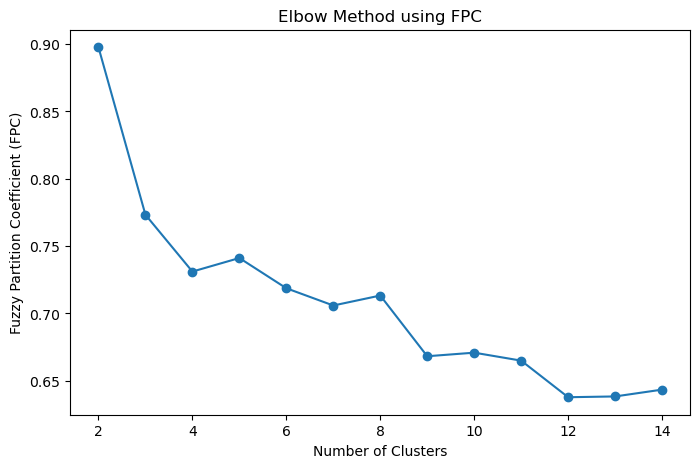

In [108]:
# Try different numbers of clusters
n_clusters_range = range(2, 15)
fpc_values = []

for n in n_clusters_range:
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
        combined_data_pca.T, n, 2, error=0.005, maxiter=1000
    )
    fpc_values.append(fpc)

# Plot the FPC values
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, fpc_values, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("Fuzzy Partition Coefficient (FPC)")
plt.title("Elbow Method using FPC")
plt.show()

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\2600384278.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_all['FCM_Cluster'] = labels


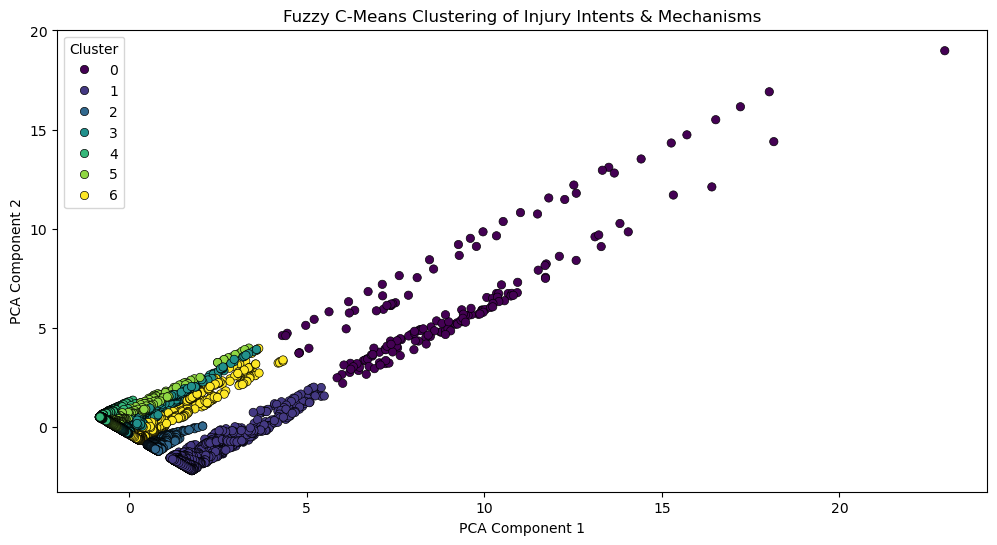

[[4.41081786e-05 3.21851451e-05 5.74323439e-05 ... 5.56521059e-05
  5.85657659e-05 6.04560531e-05]
 [7.28175610e-04 5.22766309e-04 6.71421073e-04 ... 6.65524899e-04
  6.98809307e-04 7.20381009e-04]
 [2.24457459e-03 1.59081253e-03 1.62953331e-03 ... 1.61313659e-03
  1.69155687e-03 1.74235370e-03]
 ...
 [2.13653273e-02 1.71510617e-02 9.57047580e-01 ... 9.57485580e-01
  9.55807762e-01 9.54722348e-01]
 [9.21997043e-01 9.46078539e-01 2.81221680e-02 ... 2.78753656e-02
  2.88935961e-02 2.95521722e-02]
 [6.34050463e-03 4.40407840e-03 3.31673000e-03 ... 3.26286821e-03
  3.41617082e-03 3.51541749e-03]]


In [109]:
# Optional: Reduce dimensions using PCA for better clustering
pca = PCA(n_components=2)  # Adjust based on variance explained
combined_data_pca = pca.fit_transform(combined_data)

# Fuzzy C-Means Clustering
n_clusters = 7  # Adjust as needed
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(combined_data_pca.T, n_clusters, 2, error=0.005, maxiter=1000)

# Assign clusters
labels = np.argmax(u, axis=0)
df_no_all['FCM_Cluster'] = labels

# Visualize clustering results
plt.figure(figsize=(12, 6))
sns.scatterplot(x=combined_data_pca[:, 0], y=combined_data_pca[:, 1], hue=labels, palette='viridis', edgecolor='k')
plt.title('Fuzzy C-Means Clustering of Injury Intents & Mechanisms')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster")
plt.show()

# Print fuzzy membership values (how much each point belongs to each cluster)
print(u)

In [110]:
# Run FCM on the full, preprocessed data *before* PCA
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    combined_data.T,  # Transpose your data for skfuzzy's cmeans function
    7,
    m=2,
    error=0.005,
    maxiter=1000
)
cluster_assignments = np.argmax(u, axis=0)

# Convert combined_data (NumPy array) to a DataFrame before assigning clusters
column_names = ['Deaths', 'Population'] + list(encoder.get_feature_names_out())  # Adjust as needed
df_combined = pd.DataFrame(combined_data, columns=column_names)

# Add cluster assignments
df_combined['cluster'] = cluster_assignments

# Convert one-hot encoded columns back to categorical variables
injury_intent_cols = [col for col in df_combined.columns if col.startswith('Injury Intent_')]
injury_mechanism_cols = [col for col in df_combined.columns if col.startswith('Injury Mechanism_')]

# Create new categorical columns by finding the column with value 1
df_combined['Injury Intent'] = df_combined[injury_intent_cols].idxmax(axis=1).str.replace('Injury Intent_', '', regex=False)
df_combined['Injury Mechanism'] = df_combined[injury_mechanism_cols].idxmax(axis=1).str.replace('Injury Mechanism_', '', regex=False)

# Drop the one-hot encoded columns
df_combined = df_combined.drop(columns=injury_intent_cols + injury_mechanism_cols)

In [111]:
df_combined.head()

,Deaths,Population,cluster,Injury Intent,Injury Mechanism
0,-0.191949,-0.347873,3,Unintentional,Cut/pierce
1,-0.191949,-0.371760,3,Unintentional,Cut/pierce
2,-0.191949,-0.908039,3,Unintentional,Cut/pierce
3,-0.191949,-0.086539,3,Suicide,Cut/pierce
4,-0.191949,-0.104842,3,Suicide,Cut/pierce


In [112]:
# Analyze cluster composition (as before)
cluster_analysis = df_combined.groupby('cluster').agg(
    {
        'Injury Intent': lambda x: x.value_counts().index[0],  # Most frequent intent
        'Injury Mechanism': lambda x: x.value_counts().index[0], # Most frequent mechanism
        'Deaths': 'mean',      # Average deaths
        'Population': 'mean',  # Average population
    }
)

cluster_analysis

,Injury Intent,Injury Mechanism,Deaths,Population
cluster,,,,
0,Unintentional,Firearm,0.307379,1.234036
1,Undetermined,Fall,-0.168580,0.020569
2,Unintentional,Firearm,0.324105,-0.041456
3,Unintentional,Cut/pierce,-0.134116,-0.538550
4,Undetermined,Poisoning,0.229852,-0.028728
5,Suicide,Cut/pierce,-0.159678,0.020506
6,Unintentional,Unspecified,-0.174422,0.023439


In [113]:
df_combined.groupby(['cluster', 'Injury Intent']).size().groupby(level=0).apply(lambda x: x / x.sum())

cluster  cluster  Injury Intent         
0        0        Homicide                  0.208157
                  Legal intervention/war    0.142373
                  Suicide                   0.206780
                  Undetermined              0.201377
                  Unintentional             0.241314
1        1        Homicide                  0.100000
                  Legal intervention/war    0.100000
                  Suicide                   0.100000
                  Undetermined              0.600000
                  Unintentional             0.100000
2        2        Homicide                  0.166667
                  Legal intervention/war    0.166667
                  Suicide                   0.166667
                  Unintentional             0.500000
3        3        Homicide                  0.208497
                  Legal intervention/war    0.147381
                  Suicide                   0.209006
                  Undetermined              0.211271
     

In [114]:
df_combined.groupby(['cluster', 'Injury Mechanism']).size().groupby(level=0).apply(lambda x: x / x.sum())

cluster  cluster  Injury Mechanism            
0        0        All Other Specified             0.102542
                  All Other Transport             0.101801
                  Cut/pierce                      0.101377
                  Drowning                        0.081356
                  Fall                            0.084746
                  Fire/hot object or substance    0.101907
                  Firearm                         0.109852
                  Motor vehicle traffic           0.026059
                  Poisoning                       0.104343
                  Suffocation                     0.083369
                  Unspecified                     0.102648
1        1        All Other Specified             0.200000
                  All Other Transport             0.100000
                  Fall                            0.200000
                  Fire/hot object or substance    0.100000
                  Firearm                         0.200000
         

- Since the data has many overlapping, the n_clusters = 7 with FCP of 0.7 is chosen.
- Cluster 0 (Unintentional, Firearm): Above average deaths, high population. This cluster represents unintentional firearm injuries, showing a significant impact in terms of both death rates and population size.
- Cluster 1 (Undetermined, Fall): Low deaths, low population. This group indicates injuries with undetermined intent, primarily falls. It is close to clusters with low death and population characteristics, suggesting it’s a smaller and less impactful group.
- Cluster 2 (Unintentional, Firearm): Above average deaths, slightly below average population. This cluster focuses on unintentional firearm deaths, with a slightly smaller population but a higher death count compared to other groups.
- Cluster 3 (Unintentional, Cut/Pierce): Low deaths, low population. This group represents unintentional deaths from cutting or piercing mechanisms. It has relatively low death counts and population compared to the other clusters.
- Cluster 4 (Undetermined, Poisoning): Above average deaths, low population. This cluster shows undetermined intent with poisoning as the injury mechanism. The higher death count with a lower population base highlights its significant impact on the affected individuals.
- Cluster 5 (Suicide, Cut/Pierce): Low deaths, low population. This group represents suicides resulting from cut/pierce injuries. It shows low death counts and population size, making it a relatively smaller and less widespread group.
- Cluster 6 (Unintentional, Unspecified): Low deaths, low population. This cluster includes unintentional injuries with unspecified mechanisms. With low death and population counts, it overlaps with other low-impact groups. be pattern.

The Fuzzy C-Means clustering reveals some meaningful patterns within the injury incidents, though there are areas where the results could be further refined. In the PCA plot, clusters like Cluster 2 (Unintentional, Firearm) and Cluster 6 (Unintentional, Unspecified) show moderate separation. However, Cluster 0 (Unintentional, Firearm) and Cluster 2 (Unintentional, Firearm), both related to unintentional firearm injuries, are relatively close in the PCA plot, suggesting that there may be more overlap between these groups than initially expected. Similarly, Cluster 4 (Undetermined, Poisoning) and Cluster 5 (Suicide, Cut/Pierce) show some proximity in the PCA plot, which might indicate that the relationships between injury intent and mechanism are more nuanced than what the clustering reveals. Overall, while FCM captures distinct groupings based on intent and injury mechanism, the fuzzy nature of the algorithm, combined with overlapping clusters in the PCA plot, indicates that these relationships could be more complex than the current clustering model fully conveys.

## Bias/Fairness

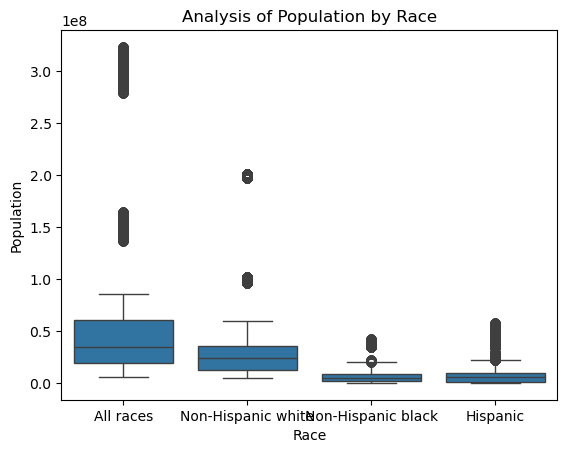

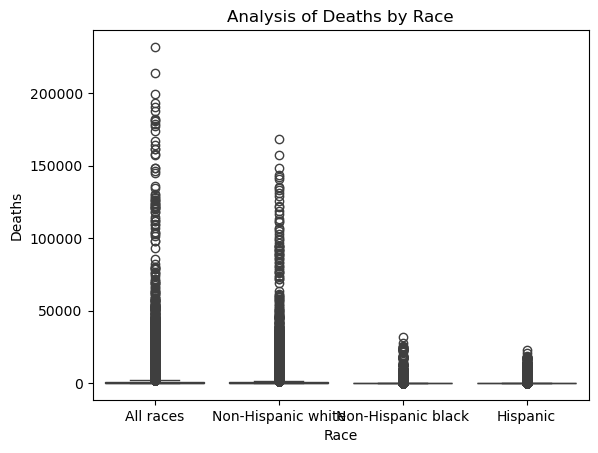

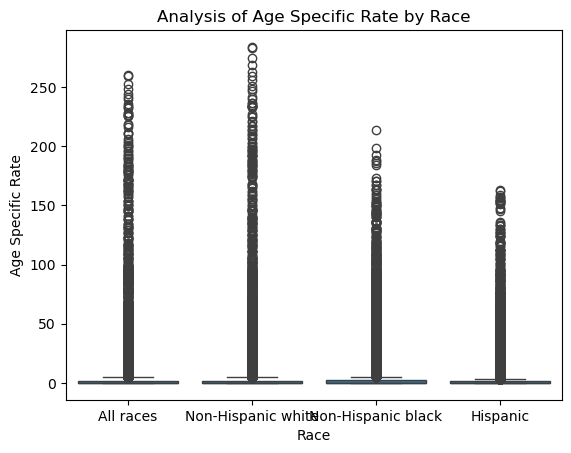

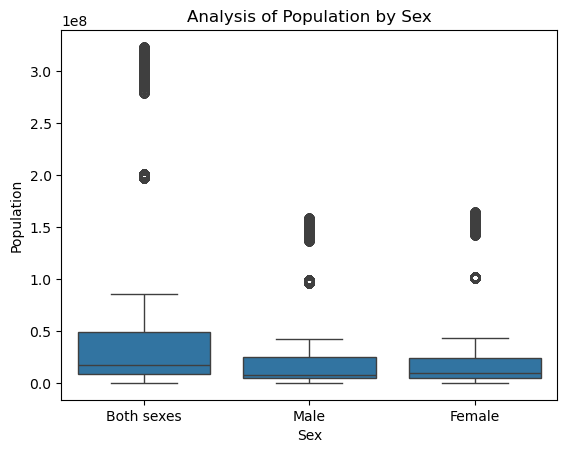

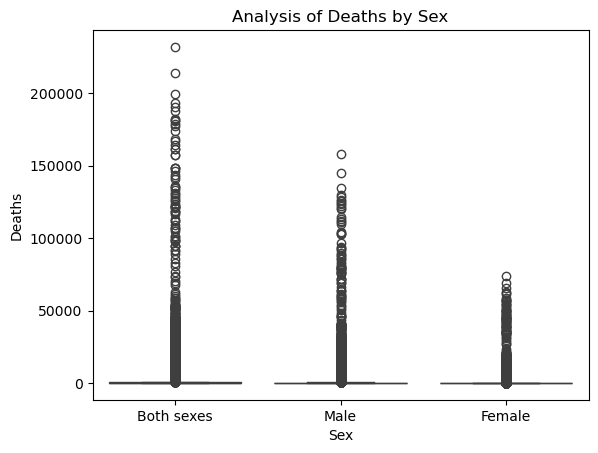

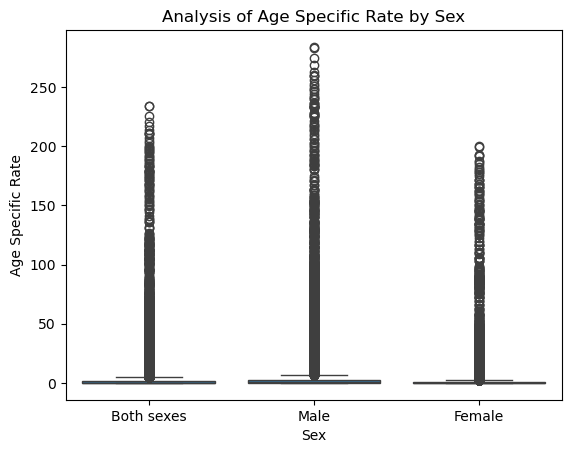

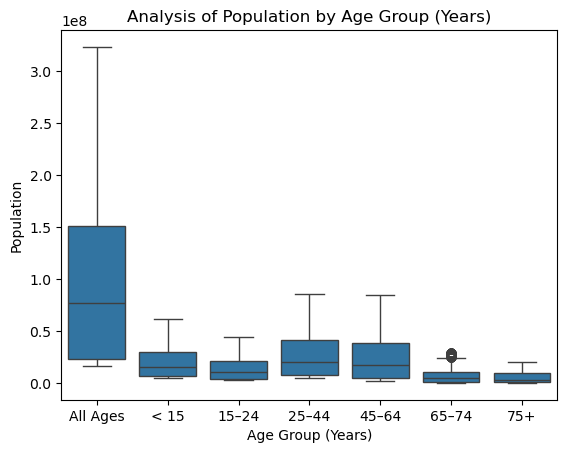

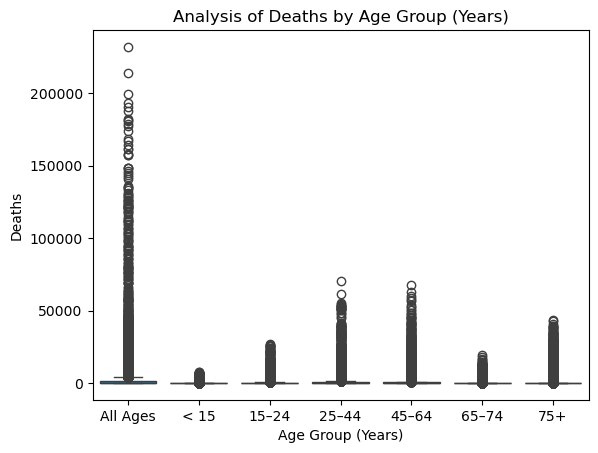

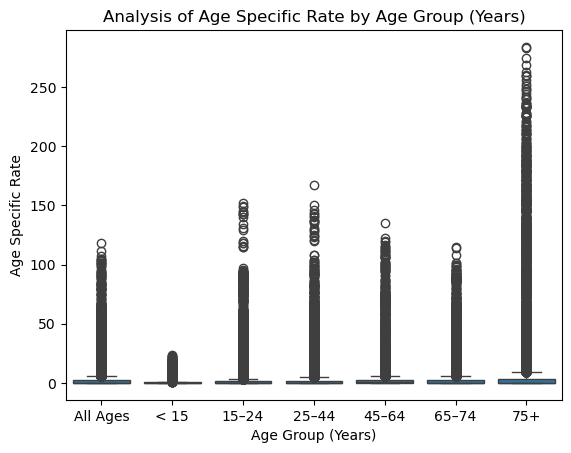

In [82]:
# Create combinations of sensitive and other features, e.g., race and population
sensitive_features = ['Race', 'Sex', 'Age Group (Years)']
other_features = ['Population', 'Deaths', 'Age Specific Rate']  # Example non-sensitive features

# Visualize correlations between sensitive features and other features
for sensitive_feature in sensitive_features:
    for other_feature in other_features:
        sns.boxplot(x=sensitive_feature, y=other_feature, data=df)
        plt.title(f"Analysis of {other_feature} by {sensitive_feature}")
        plt.show()

In [83]:
# Use chi-square test for independence between sensitive features and other features
for sensitive_feature in sensitive_features:
    for other_feature in other_features:
        contingency_table = pd.crosstab(df[sensitive_feature], df[other_feature])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f'Chi-Squared test between {sensitive_feature} and {other_feature}: p-value = {p}')
        if p < 0.05:
            print(f'There is a significant relationship between {sensitive_feature} and {other_feature}')

Chi-Squared test between Race and Population: p-value = 0.0
There is a significant relationship between Race and Population
Chi-Squared test between Race and Deaths: p-value = 8.661166326163049e-233
There is a significant relationship between Race and Deaths
Chi-Squared test between Race and Age Specific Rate: p-value = 0.0
There is a significant relationship between Race and Age Specific Rate
Chi-Squared test between Sex and Population: p-value = 0.0
There is a significant relationship between Sex and Population
Chi-Squared test between Sex and Deaths: p-value = 1.0148753938400966e-60
There is a significant relationship between Sex and Deaths
Chi-Squared test between Sex and Age Specific Rate: p-value = 0.0
There is a significant relationship between Sex and Age Specific Rate
Chi-Squared test between Age Group (Years) and Population: p-value = 0.0
There is a significant relationship between Age Group (Years) and Population
Chi-Squared test between Age Group (Years) and Deaths: p-value

To analyze injury patterns and potential biases, I grouped the features based on their relevance to injury outcomes and demographic disparities:
- Demographic Factors: These variables help identify vulnerable populations and assess inequities in injury outcomes across different demographic groups. The Chi-Square tests already suggest significant relationships, indicating that certain groups may be at higher risk.
    1. Race
    2. Sex
    3. Age Group (Years)

- Injury Characteristics: Understanding how and why injuries occur across different groups helps in targeted prevention strategies. If certain injury mechanisms are more common in specific groups, biases in policy interventions may exist (e.g., focus on firearm injuries but not poisoning).
    1. Injury Intent (Homicide, Suicide, Unintentional, etc.)
    2. Injury Mechanism (Firearm, Poisoning, Fall, etc.)

- Outcome Variables: These are the primary measures of injury severity and public health impact. Analyzing variations across groups can highlight systemic disparities in injury-related mortality.
    1. Deaths
    2. Age-Specific Rate

- Exposure Factors: Population size is crucial for normalization (e.g., rates per 100,000). Without proper scaling, bias can arise if large population groups dominate the dataset, masking smaller groups' risks.
    1. Population

There are some bias in the data
- Race-Based Bias: Deaths and Age-Specific Rates vary significantly by race, which suggests that certain racial groups may be at higher risk of injury-related fatalities. For example, in the boxplot from EDA, the age specific rate for non-hispanic black is slightly higher than non-hispanic white. The possible explanations are socioeconomic disparities, healthcare access, or systemic discrimination in safety measures and interventions.

- Sex-Based Bias: Significant differences in deaths and age-specific rates by sex suggest gendered injury risks specifically male has higher age specific rate than female. The potential causes are occupational exposure, risk-taking behaviors, or societal norms affecting injury rates differently for men and women.

- Age-Based Bias: Younger and older age groups may be disproportionately affected by certain injuries. For example, falls in elderly populations and traffic accident in younger groups.

### Hypothesis

The dataset categorizes injury deaths by intent (ex. homicide, suicide, unintentional) and by the cause of injury (ex. firearms, poisoning, falls). Bias may occur in how the clustering algorithm groups these injuries. For example, focusing on injury intent might ignore social factors that affect outcomes, like higher firearm-related deaths in certain communities due to broader social issues. If clusters favor certain injury types, such as firearms over poisoning or falls, healthcare resources may be unequally distributed, affecting certain groups more than others. This could cause the clustering model to reinforce existing biases rather than show the true patterns of injury risk.

In [84]:
# Prepare data for fairness assessment
le = LabelEncoder()

# Hierarchical Clustering
hc_data = pd.concat([
    age_summary_scaled[['Cluster_hc']].assign(Group='Age'),
    race_summary_scaled[['Cluster_hc']].assign(Group='Race'),
    sex_summary_scaled[['Cluster_hc']].assign(Group='Sex')
])
hc_data['Group'] = le.fit_transform(hc_data['Group'])

# Binarize the clustering labels
binarizer = Binarizer()
hc_data['Cluster_hc_binary'] = binarizer.fit_transform(hc_data[['Cluster_hc']])

# FCM Clustering
fcm_data = df_combined[['cluster', 'Injury Intent', 'Injury Mechanism']]
fcm_data['Injury Intent'] = le.fit_transform(fcm_data['Injury Intent'])
fcm_data['Injury Mechanism'] = le.fit_transform(fcm_data['Injury Mechanism'])

# Binarize the clustering labels
fcm_data['cluster_binary'] = binarizer.fit_transform(fcm_data[['cluster']])

# Function to calculate fairness metrics
def calculate_fairness_metrics(y_true, y_pred, sensitive_features):
    dpd = demographic_parity_difference(y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    eod = equalized_odds_difference(y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
    
    return {
        'demographic_parity': dpd,
        'equalized_odds': eod
    }

C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\490211399.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_data['Injury Intent'] = le.fit_transform(fcm_data['Injury Intent'])
C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\490211399.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_data['Injury Mechanism'] = le.fit_transform(fcm_data['Injury Mechanism'])
C:\Users\Apits\AppData\Local\Temp\ipykernel_7848\490211399.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [85]:
# Calculate fairness metrics for Hierarchical Clustering
hc_metrics = calculate_fairness_metrics(
    y_true=hc_data['Cluster_hc_binary'], 
    y_pred=hc_data['Cluster_hc_binary'], 
    sensitive_features=hc_data['Group']
)

In [86]:
# Calculate fairness metrics for FCM Clustering
fcm_metrics_intent = calculate_fairness_metrics(
    y_true=fcm_data['cluster_binary'], 
    y_pred=fcm_data['cluster_binary'], 
    sensitive_features=fcm_data['Injury Intent']
)

fcm_metrics_mechanism = calculate_fairness_metrics(
    y_true=fcm_data['cluster_binary'], 
    y_pred=fcm_data['cluster_binary'], 
    sensitive_features=fcm_data['Injury Mechanism']
)

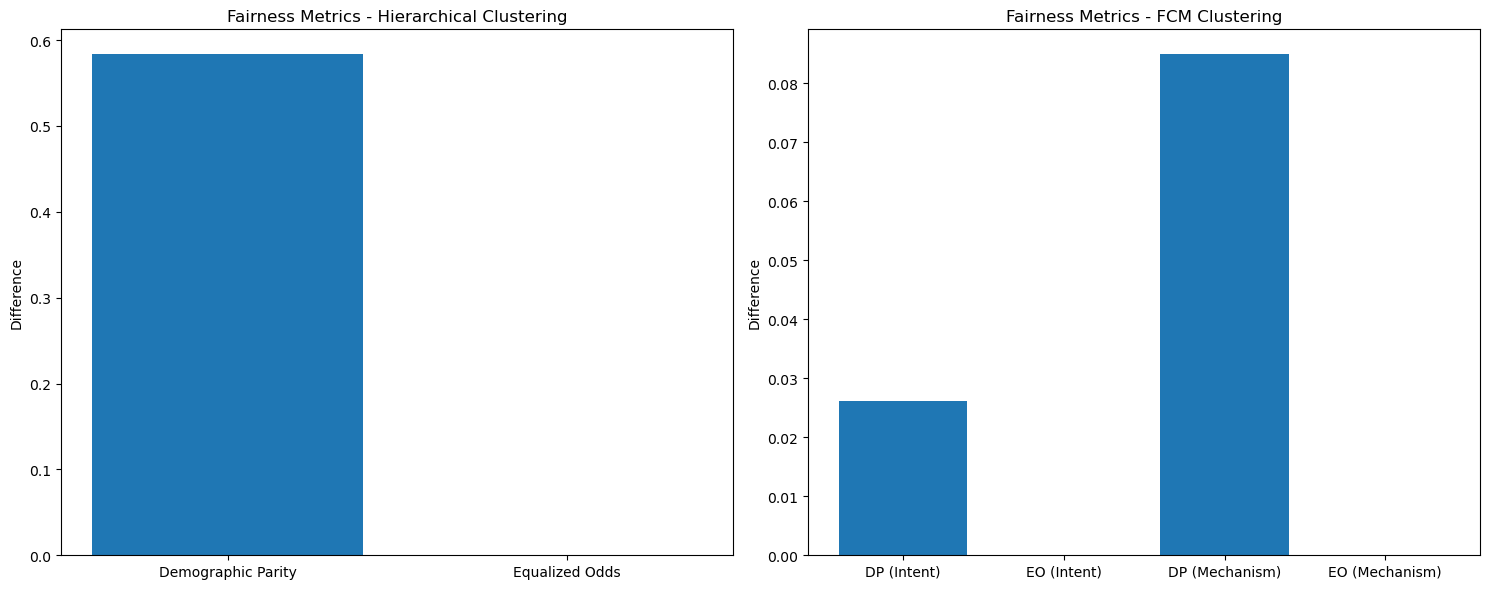

Hierarchical Clustering Fairness Metrics by Group:
{'demographic_parity': 0.5833333333333334, 'equalized_odds': 0.0}

FCM Clustering Fairness Metrics by Injury Intent:
{'demographic_parity': 0.026108305274971932, 'equalized_odds': 0.0}

FCM Clustering Fairness Metrics by Injury Mechanism:
{'demographic_parity': 0.08487654320987659, 'equalized_odds': 0.0}


In [87]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Hierarchical Clustering
ax1.bar(['Demographic Parity', 'Equalized Odds'], 
        [hc_metrics['demographic_parity'], hc_metrics['equalized_odds']])
ax1.set_title('Fairness Metrics - Hierarchical Clustering')
ax1.set_ylabel('Difference')

# FCM Clustering
ax2.bar(['DP (Intent)', 'EO (Intent)', 'DP (Mechanism)', 'EO (Mechanism)'],
        [fcm_metrics_intent['demographic_parity'], fcm_metrics_intent['equalized_odds'],
         fcm_metrics_mechanism['demographic_parity'], fcm_metrics_mechanism['equalized_odds']])
ax2.set_title('Fairness Metrics - FCM Clustering')
ax2.set_ylabel('Difference')

plt.tight_layout()
plt.show()

# Print detailed results
print("Hierarchical Clustering Fairness Metrics by Group:")
print(hc_metrics)
print("\nFCM Clustering Fairness Metrics by Injury Intent:")
print(fcm_metrics_intent)
print("\nFCM Clustering Fairness Metrics by Injury Mechanism:")
print(fcm_metrics_mechanism)

### Reasoning for Group Selection
- Age, Race, and Sex: These are common sensitive attributes that can reveal potential biases in clustering models. They are often used in fairness assessments to ensure that the model does not disproportionately affect any particular group.
- Injury Intent and Injury Mechanism: These attributes are specific to your dataset and can help identify biases related to different types of injuries. They are relevant for understanding how the clustering model treats different injury scenarios.

### Comparison of Fairness Metrics for Different Models
- Hierarchical Clustering shows a significant demographic parity difference (0.5833), indicating a notable disparity in positive outcome rates between groups. However, it has perfect equalized odds (0.0), meaning there is no difference in true positive and false positive rates between groups.
- FCM Clustering for both Injury Intent and Injury Mechanism shows low demographic parity differences (0.02 and 0.08, respectively) and perfect equalized odds (0.0). This suggests that FCM Clustering is more fair in terms of demographic parity compared to Hierarchical Clustering.
- For KMeans since it's not directly involve demographic nor injury intent/ mechanism, we will not disscuss this in bias/fairness.

### Results
- Hierarchical Clustering: The high demographic parity difference indicates that this model may be biased against certain groups. However, the equalized odds being zero suggests that the model's accuracy is consistent across groups.
- FCM Clustering: The low demographic parity differences and zero equalized odds indicate that this model is fairer and more consistent across different groups.

### Bias/Fairness Mitigation Suggestions
- Re-sampling: Adjust the dataset to balance the representation of different groups. This can help reduce biases in the model.
- Fairness Constraints: Apply fairness constraints during the clustering process to ensure that the model treats all groups fairly.
- Post-processing: Adjust the clustering results to improve fairness metrics. This can involve reassigning cluster labels to reduce disparities.